# This script will analyse a biological sample of GATTA-Cells for TD-FLIM

 Frequency of acquisition 50 Mhz
 Pixel size of 54 nm


 https://www.gattaquant.com/products/gatta-cells/gatta-cells-flim.html



GATTA-Cells 3C FLIM

Multicolor U2OS cells displaying 3 colors

Nucleus: DAPI

Mitochondria: Tom20 with Alexa Fluor 532

Microtubules: α-Tubulin with Alexa Fluor 555


1.   Alexa Fluor 532 tau2 = 2.5 ns
2.   Alexa Fluor 555 tau1 = 0.3 ns



## Parameters

In [125]:
### Acquisition parameters
frequency = 50 # MHz

### Parameters for MSSR
sigma_px = 2.43
fwhm = 2.35 * sigma_px  # Full Width at Half Maximum
amp = 1  # Amplitude
order = 1  # Order
mesh = True  # Optional, default is True
ftI = False  # Optional, default is False
intNorm = False  # Optional, default is True

## Mount google drive

In [126]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Install libraries

In [127]:
# Uncomment to install
print("Installing necessary libraries...")
#!pip install numpy==1.26.0 >  /dev/null 2>&1
#!pip install phasorpy > /dev/null 2>&1
#!pip install PyQt5 > /dev/null 2>&1
#!pip install napari[all] > /dev/null 2>&1
#!pip install git+https://github.com/RoccoDAnt/napari-superres.git > /dev/null 2>&1
#!pip install cmcrameri
print("Libraries installed successfully.")

Installing necessary libraries...
Libraries installed successfully.


## Load required libraries

In [128]:
import pandas as pd
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
from scipy.ndimage import gaussian_filter

# Libraries for computing phasor metrics
from scipy.linalg import eigh
import math
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import auc
from scipy.ndimage import gaussian_filter1d
from scipy.stats import entropy, ks_2samp, linregress
from scipy.signal import find_peaks
from scipy.signal import savgol_filter

from phasorpy.plot import plot_phasor_image, PhasorPlot, plot_phasor
from phasorpy.phasor import phasor_threshold, phasor_filter_median, phasor_to_principal_plane, phasor_from_signal#, phasor_to_apparent_lifetime
from phasorpy.lifetime import phasor_to_apparent_lifetime, phasor_from_lifetime, phasor_semicircle, lifetime_to_signal, phasor_calibrate


from phasorpy.color import CATEGORICAL
from phasorpy.cursor import (
    mask_from_circular_cursor,
    mask_from_elliptic_cursor,
    mask_from_polar_cursor,
    pseudo_color,
)

from napari_superres.core_mssr import mssr_class
mssr_instance = mssr_class()

import cmcrameri.cm as cmc

## Functions for computing phasor metrics

In [129]:
def phasor_centroid_and_cov(G, S, mask=None):
    """
    Compute centroid and covariance of phasor points from 2D arrays G and S.
    NaNs are ignored. A mask can further restrict valid pixels.
    """
    G = np.array(G, dtype=float)
    S = np.array(S, dtype=float)

    # Flatten and apply mask
    if mask is not None:
        mask = np.array(mask, dtype=bool)
        G = G[mask]
        S = S[mask]
    else:
        G = G.ravel()
        S = S.ravel()

    # Remove NaNs
    valid = np.isfinite(G) & np.isfinite(S)
    G = G[valid]
    S = S[valid]

    if G.size == 0:
        return (np.nan, np.nan), np.full((2, 2), np.nan), 0

    pts = np.vstack([G, S])
    centroid = np.mean(pts, axis=1)
    cov = np.cov(pts)
    return (centroid[0], centroid[1]), cov, len(G)


def confidence_ellipse_params(cov, confidence=0.95):
    """
    Compute parameters of the confidence ellipse for a 2D Gaussian distribution.
    Returns semi-axis lengths (a, b), area, and anisotropy (a/b).
    """
    chi2_map = {0.68: 2.279, 0.95: 5.991, 0.99: 9.21}
    chi2 = chi2_map.get(confidence, 5.991)

    if np.any(np.isnan(cov)):
        return np.nan, np.nan, np.nan, np.nan

    # Eigenvalues of covariance matrix
    vals, _ = eigh(cov)
    vals = np.sort(vals)  # ensure order

    a = np.sqrt(vals[1] * chi2)  # major semi-axis
    b = np.sqrt(vals[0] * chi2)  # minor semi-axis
    area = np.pi * a * b
    anisotropy = a / b if b > 0 else np.nan

    return a, b, area, anisotropy

def ellipse_orientation(cov):
    """
    Compute orientation of the ellipse (in radians) from covariance matrix.
    Returns angle of the major axis with respect to the G-axis.
    """
    if np.any(np.isnan(cov)):
        return np.nan
    sigma_GG = cov[0, 0]
    sigma_SS = cov[1, 1]
    sigma_GS = cov[0, 1]
    theta = 0.5 * np.arctan2(2 * sigma_GS, sigma_GG - sigma_SS)
    return theta  # radians


def compute_phasor_metrics(G_before, S_before, G_after, S_after, mask=None):
    results = {}

    # Before MSSR
    cent_b, cov_b, n_b = phasor_centroid_and_cov(G_before, S_before, mask)
    a_b, b_b, area_b, aniso_b = confidence_ellipse_params(cov_b)
    theta_b = ellipse_orientation(cov_b)

    # After MSSR
    cent_a, cov_a, n_a = phasor_centroid_and_cov(G_after, S_after, mask)
    a_a, b_a, area_a, aniso_a = confidence_ellipse_params(cov_a)
    theta_a = ellipse_orientation(cov_a)

    # Metrics
    displacement = math.hypot(cent_a[0] - cent_b[0], cent_a[1] - cent_b[1])
    area_ratio = area_a / area_b if (area_b and area_b > 0) else np.nan
    aniso_ratio = aniso_a / aniso_b if (aniso_b and np.isfinite(aniso_b)) else np.nan
    dtheta = (theta_a - theta_b) * 180 / np.pi  # in degrees

    results.update({
        "n_points_before": n_b,
        "n_points_after": n_a,
        "centroid_before": cent_b,
        "centroid_after": cent_a,
        "centroid_displacement": displacement,
        "ellipse_area_before": area_b,
        "ellipse_area_after": area_a,
        "area_ratio": area_ratio,
        "anisotropy_before": aniso_b,
        "anisotropy_after": aniso_a,
        "anisotropy_ratio": aniso_ratio,
        "covariance_before": cov_b,
        "covariance_after": cov_a,
        "sigma_GS_before": cov_b[0,1],
        "sigma_GS_after": cov_a[0,1],
        "orientation_before_deg": theta_b * 180 / np.pi,
        "orientation_after_deg": theta_a * 180 / np.pi,
        "orientation_change_deg": dtheta
    })

    # --- Print results ---
    print("\n--- Phasor Metrics ---")
    for k, v in results.items():
        if isinstance(v, (float, np.floating)):   # format floats to 4 decimals
            print(f"{k:25s}: {v: .4f}")
        elif isinstance(v, (tuple, list)) and all(isinstance(x, (float, np.floating)) for x in v):
            formatted = ", ".join([f"{x:.4f}" for x in v])
            print(f"{k:25s}: ({formatted})")
        else:  # integers or other types
            print(f"{k:25s}: {v}")

    return results

def compute_fraction_metrics(
    fractions,
    y_before,
    y_after,
    window_length=11,
    polyorder=3,
    n_permutations=1000
):
    """
    Compute metrics comparing two normalized fraction histograms (before/after MSSR).
    Includes detection of the inflection point (f*) and slope at that point.

    Parameters
    ----------
    fractions : 1D array
        Fraction values (x-axis).
    y_before : 1D array
        Normalized histogram counts before MSSR.
    y_after : 1D array
        Normalized histogram counts after MSSR.
    window_length : int
        Length of the Savitzky-Golay filter window for smoothing.
    polyorder : int
        Polynomial order for smoothing.
    n_permutations : int
        Number of random permutations for permutation test.

    Returns
    -------
    dict
        Dictionary of all computed metrics.
    """

    # Ensure numpy arrays and handle NaNs
    fractions = np.asarray(fractions)
    y_before = np.nan_to_num(np.asarray(y_before), nan=0.0)
    y_after = np.nan_to_num(np.asarray(y_after), nan=0.0)

    # Normalize histograms to sum = 1
    y_before /= np.sum(y_before)
    y_after /= np.sum(y_after)

    # Smooth for derivative estimation
    yb = savgol_filter(y_before, window_length, polyorder)
    ya = savgol_filter(y_after, window_length, polyorder)

    # Basic metrics
    var_before = np.var(yb)
    var_after = np.var(ya)

    # Overlap coefficient
    overlap = np.sum(np.minimum(yb, ya))

    # Jensen-Shannon divergence
    m = 0.5 * (yb + ya)
    jsd = 0.5 * (entropy(yb, m) + entropy(ya, m))

    # Derivative to find inflection points
    dyb = np.gradient(yb, fractions)
    dya = np.gradient(ya, fractions)

    # Find inflection (maximum |slope|)
    idx_b = np.argmin(dyb)
    idx_a = np.argmin(dya)

    f_star_before = fractions[idx_b]
    f_star_after = fractions[idx_a]
    slope_before = dyb[idx_b]
    slope_after = dya[idx_a]
    delta_f_star = f_star_after - f_star_before

    # FWHM estimation
    half_max_before = np.max(yb) / 2
    half_max_after = np.max(ya) / 2
    fwhm_before = np.sum(yb > half_max_before) / len(yb)
    fwhm_after = np.sum(ya > half_max_after) / len(ya)

    # KS test
    ks_stat, ks_p = ks_2samp(yb, ya)

    # Permutation test (simplified, compares overlap)
    overlaps = []
    for _ in range(n_permutations):
        np.random.shuffle(y_after)
        overlaps.append(np.sum(np.minimum(yb, y_after)))
    perm_p = np.mean(np.array(overlaps) <= overlap)

    # Collect metrics
    metrics = {
        "variance_before": var_before,
        "variance_after": var_after,
        "overlap_coefficient": overlap,
        "JSD": jsd,
        "f_star_before": f_star_before,
        "f_star_after": f_star_after,
        "delta_f_star": delta_f_star,
        "slope_before": slope_before,
        "slope_after": slope_after,
        "FWHM_before": fwhm_before,
        "FWHM_after": fwhm_after,
        "KS_statistic": ks_stat,
        "KS_p_value": ks_p,
        "permutation_p_value": perm_p,
    }

    # Print neatly
    print("\n--- Fraction Metrics ---")
    for k, v in metrics.items():
        print(f"{k:20s}: {v: .6e}")

    return metrics


## Load data

In [130]:
# Load the uploaded files
file_g_path = "/content/drive/MyDrive/Doctorado/LNMA/2025/GATTA_QUANT/G.csv"
file_s_path = "/content/drive/MyDrive/Doctorado/LNMA/2025/GATTA_QUANT/S.csv"
image_path = "/content/drive/MyDrive/Doctorado/LNMA/2025/GATTA_QUANT/Intensity_Gatta_50Mhz_px54.tif"


# Read the CSV files
df_g = pd.read_csv(file_g_path)
df_s = pd.read_csv(file_s_path)

# Read the image
image = tifffile.imread(image_path)

In [131]:
### Function to plot histograms

def plot_histograms(
    *data,
    title=None,
    xlabel=None,
    ylabel=None,
    labels=None,
    show=True,
    title_fontsize = 18,
    label_fontsize=16,
    tick_labelsize=14,
    legend_fontsize=14,
    **kwargs,
) -> None:
    """Plot histograms of flattened data arrays.

    Parameters
    ----------
    data: array_like
        Data arrays to be plotted as histograms.
    title : str, optional
        Figure title.
    xlabel : str, optional
        Label for x-axis.
    ylabel : str, optional
        Label for y-axis.
    labels: sequence of str, optional
        Labels for each data array.
    show : bool, optional, default: True
        Display figure.
    **kwargs
        Additional arguments passed to :func:`matplotlib.pyplot.hist`.

    """
    ax = plt.subplots()[1]
    if kwargs.get('alpha') is None:
        ax.hist(
            [np.asarray(d).flatten() for d in data], label=labels, **kwargs
        )
    else:
        for d, label in zip(
            data, [None] * len(data) if labels is None else labels
        ):
            ax.hist(np.asarray(d).flatten(), label=label, **kwargs)
    if title is not None:
        ax.set_title(title, fontsize=title_fontsize)
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize = label_fontsize)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize = label_fontsize)
    if labels is not None:
        ax.legend(fontsize=legend_fontsize)
    #Tick size
    ax.tick_params(axis='both', which='major', labelsize=tick_labelsize)

    plt.tight_layout()
    if show:
        plt.show()

## Analyze and plot

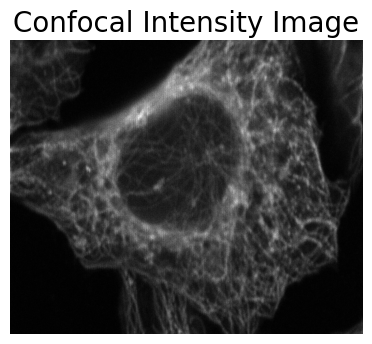

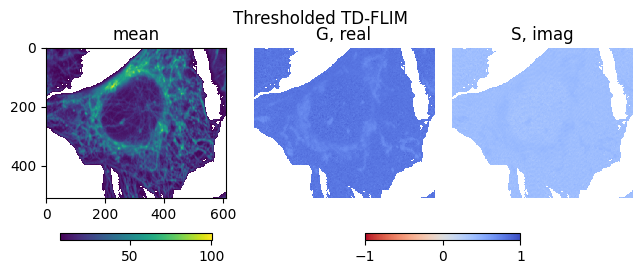

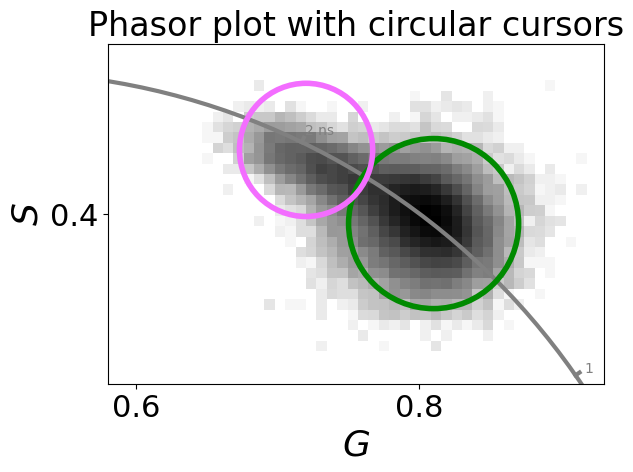

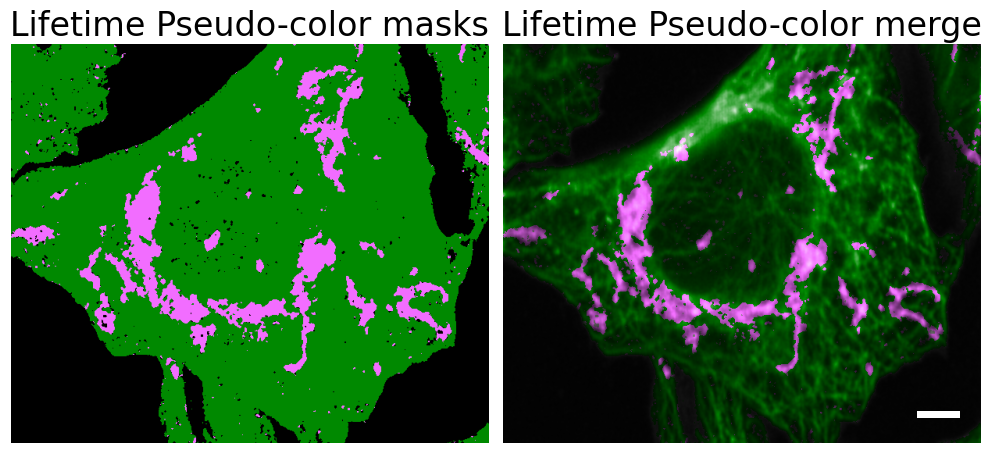

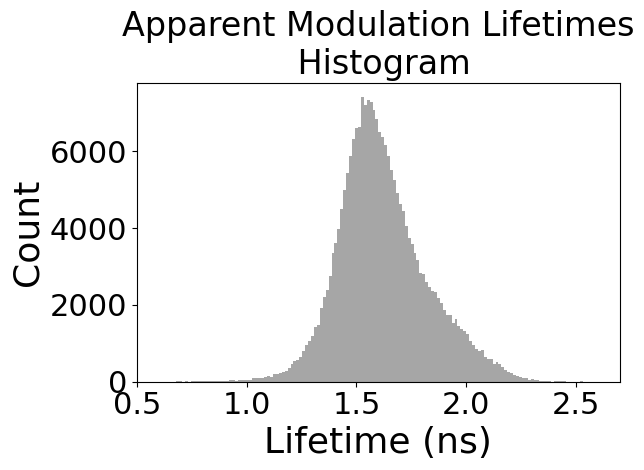

In [132]:
# Apply Gaussian blur to the entire image
sigma = 1  # standard deviation of the Gaussian kernel
blurred_image = gaussian_filter(image, sigma=sigma)

# Display original and blurred images
fontsize = 24
labelsize = 26
ticksize = 22
lw = 4

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Confocal Intensity Image", fontsize = fontsize -4)
plt.axis('off')

## Median filter
mean_mf, real_mf, imag_mf = phasor_filter_median(blurred_image, df_g, df_s, size=3, repeat=3)
## Threshold
mean_th, real_th, imag_th = phasor_threshold(mean_mf, real_mf, imag_mf, mean_min=7)


cursors_real = [0.81, 0.72]
cursors_imag = [0.393, 0.445]
radius = [0.06, 0.047]

circular_mask = mask_from_circular_cursor(
    real_th, imag_th, cursors_real, cursors_imag, radius=radius
)

########## Plot

plot_phasor_image(mean_th, real_th, imag_th, title='Thresholded TD-FLIM')

plot = PhasorPlot(allquadrants=False, title='Circular cursors')
plot.semicircle(frequency=frequency, linewidth= 3)
plot.hist2d(real_th, imag_th, cmap='Greys', bins = 150)
#for i in range(len(cursors_real)):                  #Uncomment to draw polar crosses inside circular cursors
    #plot.cursor(
        #cursors_real[i],
        #cursors_imag[i],
        #radius=radius[i],
        #crosshair=True,
        #polar=True,
        #color=CATEGORICAL[i+2],
        #linestyle='-', linewidth = lw
    #)
for i in range(len(cursors_real)):
    plot.cursor(
        cursors_real[i],
        cursors_imag[i],
        radius=radius[i],
        color=CATEGORICAL[i+2],
        linestyle='-', linewidth = lw
    )
plt.xlim(0.58, 0.93)
plt.ylim(0.28, 0.52)
plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
plt.title('Phasor plot with circular cursors', fontsize = fontsize)

plot.show()

#### Pseudo-color maps

pseudo_color_masks = pseudo_color(*circular_mask, intensity = None, colors=CATEGORICAL[2:])
pseudo_color_merge = pseudo_color(*circular_mask, intensity = blurred_image, colors=CATEGORICAL[2:])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

ax1.set_title('Lifetime Pseudo-color masks', fontsize = fontsize)
ax1.imshow(pseudo_color_masks)
ax1.axis('off')

ax2.set_title('Lifetime Pseudo-color merge', fontsize = fontsize)
ax2.imshow(pseudo_color_merge)
ax2.axis('off')

# Add the scale bar
scalebar_width = 55.5  # in pixels
scalebar_height = 8  # in pixels
bar_color = 'white'  # or 'black' depending on your image

# Position: bottom left with a 10-pixel margin
x_pos = 530
y_pos = 470

scalebar = patches.Rectangle((x_pos, y_pos), scalebar_width, scalebar_height,
                             linewidth=0, edgecolor=None, facecolor=bar_color)
ax2.add_patch(scalebar)

plt.tight_layout()
plt.show()

#### Histograms

phase_lifetime, modulation_lifetime = phasor_to_apparent_lifetime(
    real_th, imag_th, frequency
)

plot_histograms(
    modulation_lifetime,
    range=(0.6, 2.6),
    bins=150,
    alpha=0.7,
    title='Apparent Modulation Lifetimes\n Histogram',
    xlabel='Lifetime (ns)',
    ylabel='Count',
    color='gray',
    title_fontsize= fontsize,
    label_fontsize = labelsize,
    tick_labelsize = ticksize,#<- now works!
)


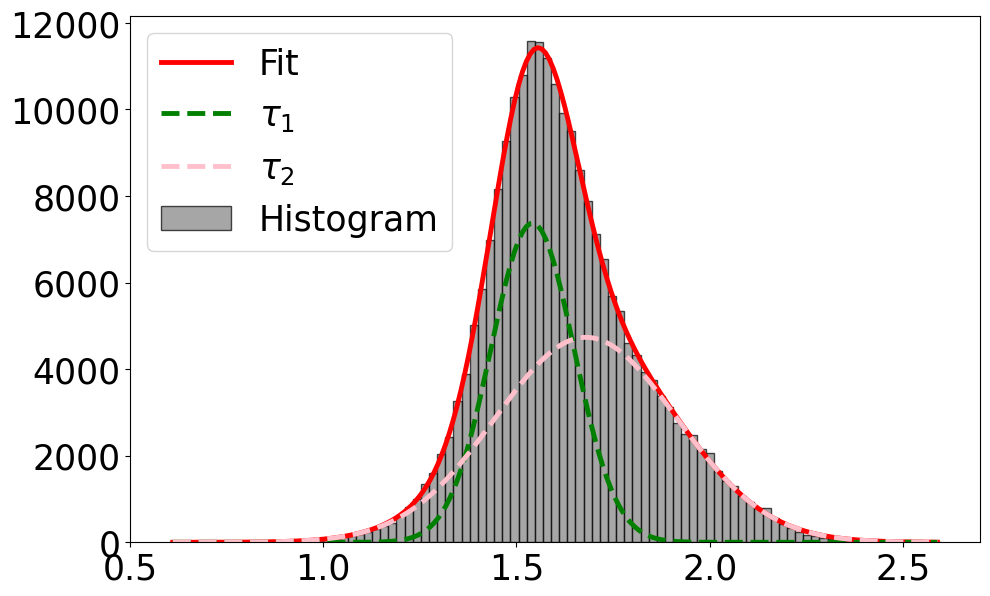

Fitted Parameters for Gaussian 1:
  Amplitude: 7373.48
  Mean: 1.54 ns
  Standard Deviation: 0.08 ns

Fitted Parameters for Gaussian 2:
  Amplitude: 4734.83
  Mean: 1.68 ns
  Standard Deviation: -0.17 ns


In [133]:
# prompt: Adjust two independent gaussians to the histogram above

from scipy.optimize import curve_fit
from scipy.stats import norm

legend_fontsize = 25

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / (2 * stddev))**2)

def double_gaussian(x, amp1, mean1, stddev1, amp2, mean2, stddev2):
    return gaussian(x, amp1, mean1, stddev1) + gaussian(x, amp2, mean2, stddev2)

fontsize = 30
labelsize = 28
ticksize = 25
lw = 3.5
# Get the histogram data
hist, bin_edges = np.histogram(np.asarray(modulation_lifetime).flatten(), bins=95, range=(0.6, 2.6))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Initial guesses for the parameters (amplitude, mean, stddev) for each gaussian
# You might need to adjust these based on the visual inspection of your histogram
initial_guess = [
    np.max(hist), 0.5, 0.1,  # Guess for the first peak
    np.max(hist), 2.4, 0.1   # Guess for the second peak
]

# Fit the double gaussian function to the histogram data
try:
    params, covariance = curve_fit(double_gaussian, bin_centers, hist, p0=initial_guess)

    # Extract the parameters for each gaussian
    amp1, mean1, stddev1, amp2, mean2, stddev2 = params

    # Generate the fitted curve
    x_fit = np.linspace(bin_centers[0], bin_centers[-1], 200)
    y_fit = double_gaussian(x_fit, *params)

    # Plot the histogram and the fitted double gaussian
    plt.figure(figsize=(10, 6))
    plt.bar(bin_centers, hist, width=(bin_edges[1] - bin_edges[0]), color='gray', alpha=0.7, label='Histogram', edgecolor='k')
    plt.plot(x_fit, y_fit, color='red', linestyle='-', linewidth=lw, label='Fit')
    plt.plot(x_fit, gaussian(x_fit, amp1, mean1, stddev1), color='green', linestyle='--', linewidth=lw, label=f'$\u03c4_1$')                #Gaussian 1 (mean={mean1:.2f} ns, std={stddev1:.2f} ns)')
    plt.plot(x_fit, gaussian(x_fit, amp2, mean2, stddev2), color='pink', linestyle='--', linewidth=lw, label=f'$\u03c4_2$')                 #Gaussian 2 (mean={mean2:.2f} ns, std={stddev2:.2f} ns)')

    #plt.title('Apparent Modulation Lifetimes Histogram', fontsize=fontsize)
    #plt.xlabel('Lifetime (ns)', fontsize=labelsize)
    #plt.ylabel('Count', fontsize=labelsize)
    plt.tick_params(axis='both', which='major', labelsize=ticksize)
    plt.legend(fontsize=legend_fontsize, loc = 2)
    #plt.grid(axis='y', alpha=0.5)
    plt.tight_layout()
    plt.show()

    print("Fitted Parameters for Gaussian 1:")
    print(f"  Amplitude: {amp1:.2f}")
    print(f"  Mean: {mean1:.2f} ns")
    print(f"  Standard Deviation: {stddev1:.2f} ns")

    print("\nFitted Parameters for Gaussian 2:")
    print(f"  Amplitude: {amp2:.2f}")
    print(f"  Mean: {mean2:.2f} ns")
    print(f"  Standard Deviation: {stddev2:.2f} ns")

except RuntimeError as e:
    print(f"Could not fit the curve: {e}")
    print("Please check your initial guesses or the data.")


## Lets show the temporal blurring

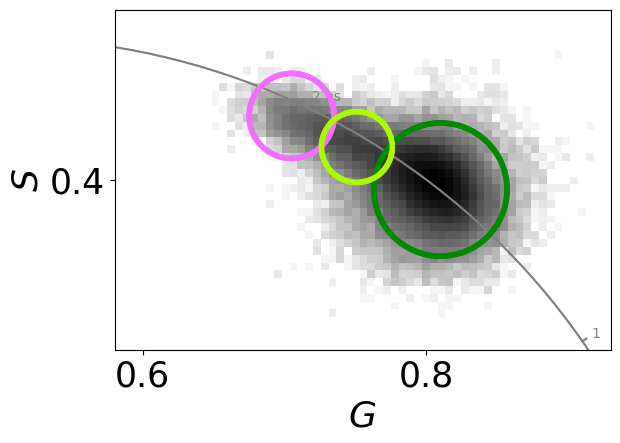

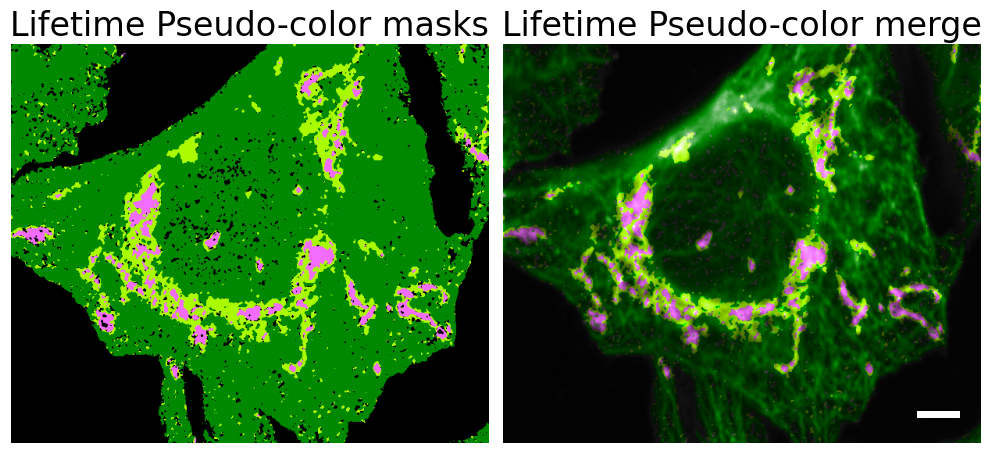

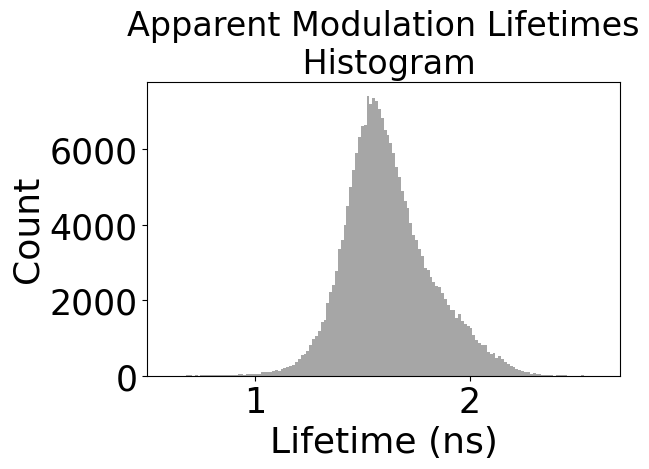

In [134]:
fontsize = 24
labelsize = 26
ticksize = 25
lw = 4

cursors_real = [0.81, 0.705,0.01, 0.751]
cursors_imag = [0.393, 0.445,0.01, 0.423]
radius = [0.047, 0.03,0.01, 0.025]

circular_mask = mask_from_circular_cursor(
    real_th, imag_th, cursors_real, cursors_imag, radius=radius
)


plot = PhasorPlot(allquadrants=False, title='Phasor Plot')
plot.semicircle(frequency=frequency, linewidth= 1.5)
plot.hist2d(real_th, imag_th, cmap='Greys', bins = 200)
plt.xlim(0.58, 0.93)
plt.ylim(0.28, 0.52)
for i in range(len(cursors_real)):
    plot.cursor(
        cursors_real[i],
        cursors_imag[i],
        radius=radius[i],
       # crosshair=True,
        #polar=True,
        color=CATEGORICAL[i+2],
        linestyle='-', linewidth = lw
    )
for i in range(len(cursors_real)):
    plot.cursor(
        cursors_real[i],
        cursors_imag[i],
        radius=radius[i],
        #crosshair=True,
        color=CATEGORICAL[i+2],
        linestyle='-', linewidth = lw
    )
plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', which='major', labelsize=ticksize) # Adjust labelsize as needed
plt.title('', fontsize = fontsize) #Phasor plot with circular cursors
plot.show()


pseudo_color_masks = pseudo_color(*circular_mask, intensity = None, colors=CATEGORICAL[2:])
pseudo_color_merge = pseudo_color(*circular_mask, intensity = blurred_image, colors=CATEGORICAL[2:])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

ax1.set_title('Lifetime Pseudo-color masks', fontsize = fontsize)
ax1.imshow(pseudo_color_masks)
ax1.axis('off')

ax2.set_title('Lifetime Pseudo-color merge', fontsize = fontsize)
ax2.imshow(pseudo_color_merge)
ax2.axis('off')

# Add the scale bar
scalebar_width = 55.5  # in pixels
scalebar_height = 8  # in pixels
bar_color = 'white'  # or 'black' depending on your image

# Position: bottom left with a 10-pixel margin
x_pos = 530
y_pos = 470

scalebar = patches.Rectangle((x_pos, y_pos), scalebar_width, scalebar_height,
                             linewidth=0, edgecolor=None, facecolor=bar_color)
ax2.add_patch(scalebar)

plt.tight_layout()
plt.show()

#### Histograms

phase_lifetime, modulation_lifetime = phasor_to_apparent_lifetime(
    real_th, imag_th, frequency
)

plot_histograms(
    modulation_lifetime,
    range=(0.6, 2.6),
    bins=150,
    alpha=0.7,
    title='Apparent Modulation Lifetimes\n Histogram',
    xlabel='Lifetime (ns)',
    ylabel='Count',
    color='gray',
    title_fontsize= fontsize,
    label_fontsize = labelsize,
    tick_labelsize = ticksize,
)

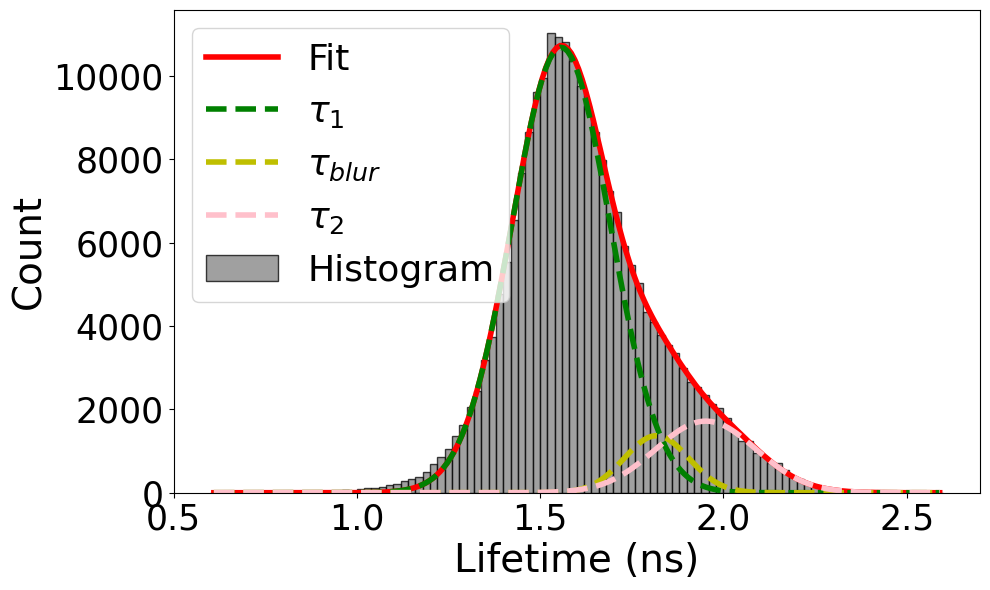

Fitted Parameters for Gaussian 1:
  Amplitude: 10687.52
  Mean: 1.56 ns
  Standard Deviation: 0.09 ns

Fitted Parameters for Gaussian 2:
  Amplitude: 1368.82
  Mean: 1.82 ns
  Standard Deviation: 0.06 ns

Fitted Parameters for Gaussian 3:
  Amplitude: 1717.84
  Mean: 1.95 ns
  Standard Deviation: 0.10 ns


In [135]:
# prompt: Fit three independent gaussians into the histogram above

def triple_gaussian(x, amp1, mean1, stddev1, amp2, mean2, stddev2, amp3, mean3, stddev3):
    return gaussian(x, amp1, mean1, stddev1) + gaussian(x, amp2, mean2, stddev2) + gaussian(x, amp3, mean3, stddev3)

fontsize = 30
labelsize = 28
ticksize = 25
legend_fontsize = 26

lw = 4
# Get the histogram data
hist, bin_edges = np.histogram(np.asarray(modulation_lifetime).flatten(), bins=100, range=(0.6, 2.6))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Initial guesses for the parameters (amplitude, mean, stddev) for each gaussian
# You will need to adjust these based on the visual inspection of your histogram
# These are just placeholders; observe the histogram peaks to make better initial guesses.
# For example, look for the approximate x-values of the peaks and their heights.
initial_guess = [
    np.max(hist) / 3, 1.5, 0.04,  # Guess for the first peak (adjust mean and stddev)
    np.max(hist) / 3, 1.9, 0.03,  # Guess for the second peak (adjust mean and stddev)
    np.max(hist) / 3, 2.2, 0.02   # Guess for the third peak (adjust mean and stddev)
]

# Fit the triple gaussian function to the histogram data
try:
    # Bounds for parameters can help the fitting process if you have an idea of the valid range.
    # For example, means should be within the data range, stddevs positive.
    # bounds = ([0, 0.4, 0, 0, 0.4, 0, 0, 0.4, 0], [np.inf, 1.6, np.inf, np.inf, 1.6, np.inf, np.inf, 1.6, np.inf])
    # params, covariance = curve_fit(triple_gaussian, bin_centers, hist, p0=initial_guess, bounds=bounds)

    # Let's try fitting without bounds first, as bounds can sometimes be tricky
    params, covariance = curve_fit(triple_gaussian, bin_centers, hist, p0=initial_guess)


    # Extract the parameters for each gaussian
    amp1, mean1, stddev1, amp2, mean2, stddev2, amp3, mean3, stddev3 = params

    # Generate the fitted curve
    x_fit = np.linspace(bin_centers[0], bin_centers[-1], 200)
    y_fit = triple_gaussian(x_fit, *params)

    # Plot the histogram and the fitted triple gaussian
    plt.figure(figsize=(10, 6))
    plt.bar(bin_centers, hist, width=(bin_edges[1] - bin_edges[0]), color='gray', alpha=0.75, label='Histogram', edgecolor='k')
    plt.plot(x_fit, y_fit, color='red', linestyle='-', linewidth=lw, label='Fit')
    plt.plot(x_fit, gaussian(x_fit, amp1, mean1, stddev1), color='green', linestyle='--', linewidth=lw, label=f'$\u03c4_1$')                         #Gaussian 1 (mean={mean1:.2f} ns, std={stddev1:.2f} ns)')
    plt.plot(x_fit, gaussian(x_fit, amp2, mean2, stddev2), color='y', linestyle='--', linewidth=lw, label='$\u03c4_{blur}$')                        #Gaussian 2 (mean={mean2:.2f} ns, std={stddev2:.2f} ns)')
    plt.plot(x_fit, gaussian(x_fit, amp3, mean3, stddev3), color='pink', linestyle='--', linewidth=lw, label=f'$\u03c4_2$')                       #Gaussian 3 (mean={mean3:.2f} ns, std={stddev3:.2f} ns)')

    #plt.title('Apparent Modulation Lifetimes Histogram', fontsize=fontsize)
    plt.xlabel('Lifetime (ns)', fontsize=labelsize)
    plt.ylabel('Count', fontsize=labelsize)
    plt.tick_params(axis='both', which='major', labelsize=ticksize)
    plt.legend(fontsize=legend_fontsize, loc = 2)
    #plt.grid(axis='y', alpha=0.5)
    plt.tight_layout()
    plt.show()

    print("Fitted Parameters for Gaussian 1:")
    print(f"  Amplitude: {amp1:.2f}")
    print(f"  Mean: {mean1:.2f} ns")
    print(f"  Standard Deviation: {stddev1:.2f} ns")

    print("\nFitted Parameters for Gaussian 2:")
    print(f"  Amplitude: {amp2:.2f}")
    print(f"  Mean: {mean2:.2f} ns")
    print(f"  Standard Deviation: {stddev2:.2f} ns")

    print("\nFitted Parameters for Gaussian 3:")
    print(f"  Amplitude: {amp3:.2f}")
    print(f"  Mean: {mean3:.2f} ns")
    print(f"  Standard Deviation: {stddev3:.2f} ns")


except RuntimeError as e:
    print(f"Could not fit the curve: {e}")
    print("Please check your initial guesses or the data.")


## Sharpen the mean image with MSSR

progress: 100%|██████████| 7/7 [00:00<00:00, 45.87it/s]


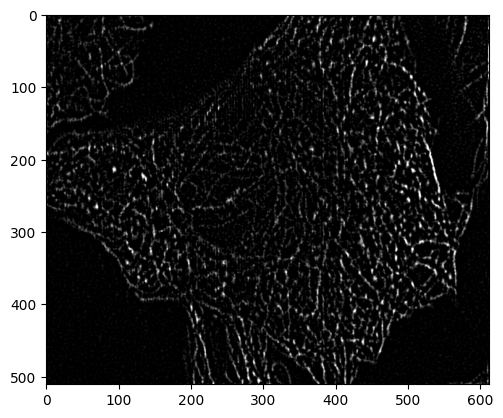

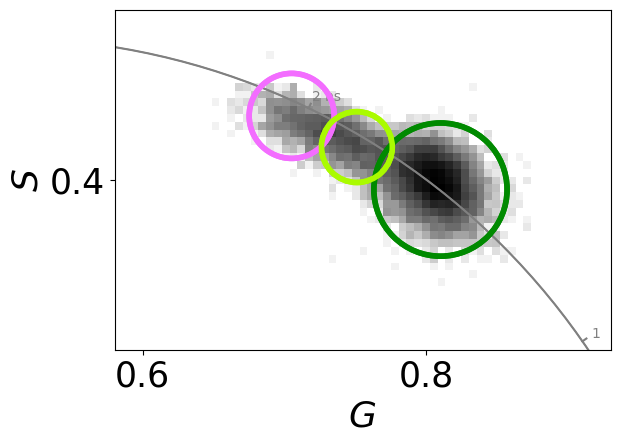

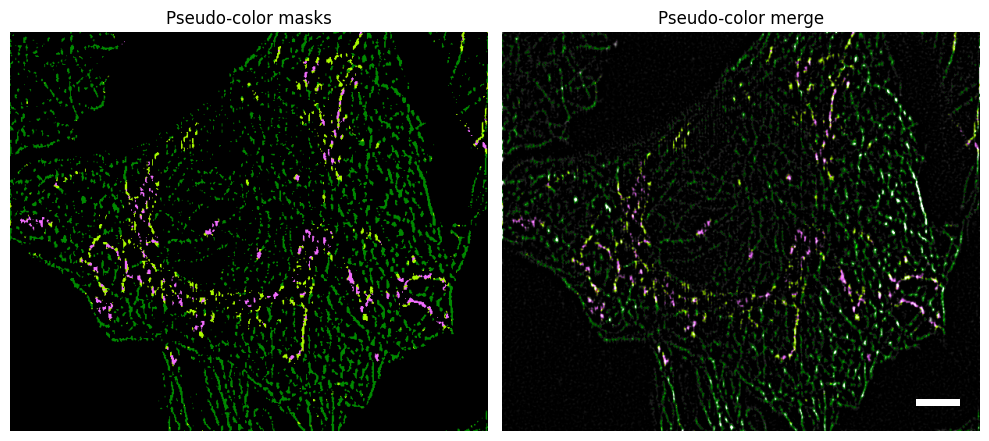

In [136]:
fontsize = 0
labelsize = 26
ticksize = 25
lw = 4

#Parameters for scale bar (Change according to the size of the image analyzed)

scalebar_width = 55.5  # in pixels
scalebar_height = 8
# Position: bottom left with a 10-pixel margin
x_pos = 530
y_pos = 470
bar_color = 'white'  # or 'black' depending on your image

#Apply MSSR1
mean_mssr1 = mssr_instance.sfMSSR(img=blurred_image, fwhm=fwhm, amp=amp, order=order, mesh=mesh, ftI=ftI, intNorm=intNorm)


plt.imshow(mean_mssr1, cmap='gray', vmin=0, vmax=0.25)

## Threshold
mean_th_mssr1, real_th_mssr1, imag_th_mssr1 = phasor_threshold(mean_mssr1, real_mf, imag_mf, mean_min=0.04)

cursors_real = [0.81, 0.705, 0.01, 0.751]      # cursors_real = [0.82, 0.7, 0.755]
cursors_imag = [0.393, 0.445, 0.01, 0.423]      # cursors_imag = [0.39, 0.445, 0.42]
radius = [0.047, 0.03, 0.01, 0.025]           # radius = [0.04, 0.03, 0.03]

circular_mask = mask_from_circular_cursor(
    real_th_mssr1, imag_th_mssr1, cursors_real, cursors_imag, radius=radius
)


plot = PhasorPlot(allquadrants=False, title='Phasor Plot')
plot.semicircle(frequency=frequency, linewidth= 1.5)
plot.hist2d(real_th_mssr1, imag_th_mssr1, cmap='Grays', bins = 200)
plt.xlim(0.58, 0.93)
plt.ylim(0.28, 0.52)
for i in range(len(cursors_real)):
    plot.cursor(
        cursors_real[i],
        cursors_imag[i],
        radius=radius[i],
        #crosshair=True,
        polar=True,
        color=CATEGORICAL[i+2],
        linestyle='-', linewidth = lw
    )
for i in range(len(cursors_real)):
    plot.cursor(
        cursors_real[i],
        cursors_imag[i],
        radius=radius[i],
        #crosshair=True,
        color=CATEGORICAL[i+2],
        linestyle='-', linewidth = lw
    )
plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', which='major', labelsize=ticksize) # Adjust labelsize as needed
plt.title('', fontsize = fontsize)
plot.show()


pseudo_color_masks = pseudo_color(*circular_mask, intensity = None, colors=CATEGORICAL[2:])
pseudo_color_merge = pseudo_color(*circular_mask, intensity = mean_mssr1, colors=CATEGORICAL[2:], vmin=0, vmax=0.25)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

ax1.set_title('Pseudo-color masks')
ax1.imshow(pseudo_color_masks)
ax1.axis('off')

ax2.set_title('Pseudo-color merge')
ax2.imshow(pseudo_color_merge)
ax2.axis('off')

# Add the scale bar
scalebar = patches.Rectangle((x_pos, y_pos), scalebar_width, scalebar_height,
                             linewidth=0, edgecolor=None, facecolor=bar_color)
ax2.add_patch(scalebar)

plt.tight_layout()
plt.show()

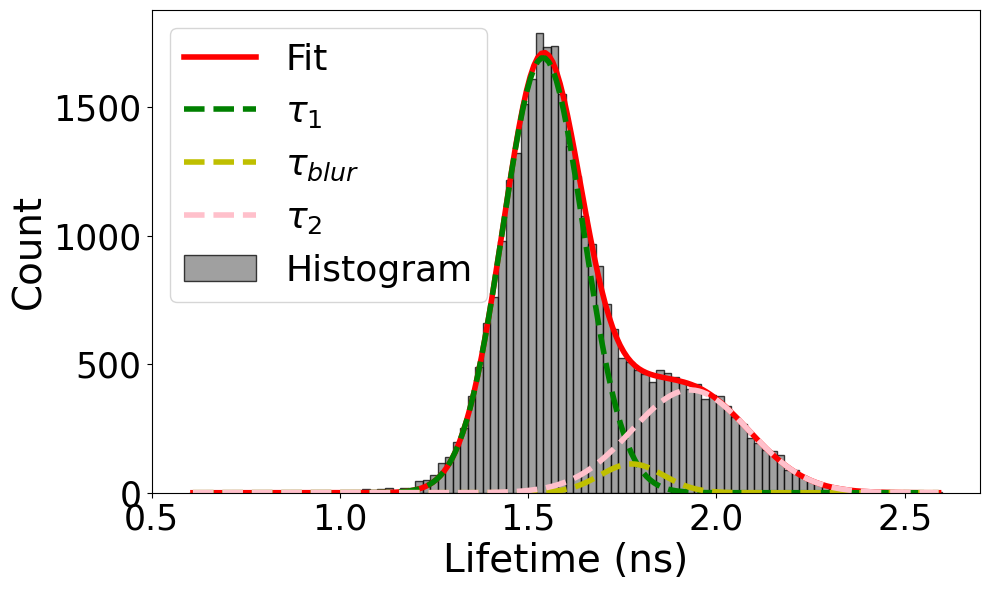

Fitted Parameters for Gaussian 1:
  Amplitude: 1693.22
  Mean: 1.54 ns
  Standard Deviation: 0.08 ns

Fitted Parameters for Gaussian 2:
  Amplitude: 112.03
  Mean: 1.78 ns
  Standard Deviation: 0.06 ns

Fitted Parameters for Gaussian 3:
  Amplitude: 399.89
  Mean: 1.93 ns
  Standard Deviation: 0.11 ns


In [137]:
def triple_gaussian(x, amp1, mean1, stddev1, amp2, mean2, stddev2, amp3, mean3, stddev3):
    return gaussian(x, amp1, mean1, stddev1) + gaussian(x, amp2, mean2, stddev2) + gaussian(x, amp3, mean3, stddev3)

fontsize = 30
labelsize = 28
ticksize = 25
legend_fontsize = 26

lw = 4

phase_lifetime, modulation_lifetime = phasor_to_apparent_lifetime(
    real_th_mssr1, imag_th_mssr1, frequency
)

# Get the histogram data
hist, bin_edges = np.histogram(np.asarray(modulation_lifetime).flatten(), bins=100, range=(0.6, 2.6))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Initial guesses for the parameters (amplitude, mean, stddev) for each gaussian
# You will need to adjust these based on the visual inspection of your histogram
# These are just placeholders; observe the histogram peaks to make better initial guesses.
# For example, look for the approximate x-values of the peaks and their heights.
initial_guess = [
    np.max(hist) / 3, 1.5, 0.04,  # Guess for the first peak (adjust mean and stddev)
    np.max(hist) / 3, 1.9, 0.03,  # Guess for the second peak (adjust mean and stddev)
    np.max(hist) / 3, 2.2, 0.02   # Guess for the third peak (adjust mean and stddev)
]

# Fit the triple gaussian function to the histogram data
try:
    # Bounds for parameters can help the fitting process if you have an idea of the valid range.
    # For example, means should be within the data range, stddevs positive.
    # bounds = ([0, 0.4, 0, 0, 0.4, 0, 0, 0.4, 0], [np.inf, 1.6, np.inf, np.inf, 1.6, np.inf, np.inf, 1.6, np.inf])
    # params, covariance = curve_fit(triple_gaussian, bin_centers, hist, p0=initial_guess, bounds=bounds)

    # Let's try fitting without bounds first, as bounds can sometimes be tricky
    params, covariance = curve_fit(triple_gaussian, bin_centers, hist, p0=initial_guess)


    # Extract the parameters for each gaussian
    amp1, mean1, stddev1, amp2, mean2, stddev2, amp3, mean3, stddev3 = params

    # Generate the fitted curve
    x_fit = np.linspace(bin_centers[0], bin_centers[-1], 200)
    y_fit = triple_gaussian(x_fit, *params)

    # Plot the histogram and the fitted triple gaussian
    plt.figure(figsize=(10, 6))
    plt.bar(bin_centers, hist, width=(bin_edges[1] - bin_edges[0]), color='gray', alpha=0.75, label='Histogram', edgecolor='k')
    plt.plot(x_fit, y_fit, color='red', linestyle='-', linewidth=lw, label='Fit')
    plt.plot(x_fit, gaussian(x_fit, amp1, mean1, stddev1), color='green', linestyle='--', linewidth=lw, label=f'$\u03c4_1$')                         #Gaussian 1 (mean={mean1:.2f} ns, std={stddev1:.2f} ns)')
    plt.plot(x_fit, gaussian(x_fit, amp2, mean2, stddev2), color='y', linestyle='--', linewidth=lw, label='$\u03c4_{blur}$')                        #Gaussian 2 (mean={mean2:.2f} ns, std={stddev2:.2f} ns)')
    plt.plot(x_fit, gaussian(x_fit, amp3, mean3, stddev3), color='pink', linestyle='--', linewidth=lw, label=f'$\u03c4_2$')                       #Gaussian 3 (mean={mean3:.2f} ns, std={stddev3:.2f} ns)')

    #plt.title('Apparent Modulation Lifetimes Histogram', fontsize=fontsize)
    plt.xlabel('Lifetime (ns)', fontsize=labelsize)
    plt.ylabel('Count', fontsize=labelsize)
    plt.tick_params(axis='both', which='major', labelsize=ticksize)
    plt.legend(fontsize=legend_fontsize, loc = 2)
    #plt.grid(axis='y', alpha=0.5)
    plt.tight_layout()
    plt.show()

    print("Fitted Parameters for Gaussian 1:")
    print(f"  Amplitude: {amp1:.2f}")
    print(f"  Mean: {mean1:.2f} ns")
    print(f"  Standard Deviation: {stddev1:.2f} ns")

    print("\nFitted Parameters for Gaussian 2:")
    print(f"  Amplitude: {amp2:.2f}")
    print(f"  Mean: {mean2:.2f} ns")
    print(f"  Standard Deviation: {stddev2:.2f} ns")

    print("\nFitted Parameters for Gaussian 3:")
    print(f"  Amplitude: {amp3:.2f}")
    print(f"  Mean: {mean3:.2f} ns")
    print(f"  Standard Deviation: {stddev3:.2f} ns")


except RuntimeError as e:
    print(f"Could not fit the curve: {e}")
    print("Please check your initial guesses or the data.")

# Regions of interest (Zoom)

(100, 100)


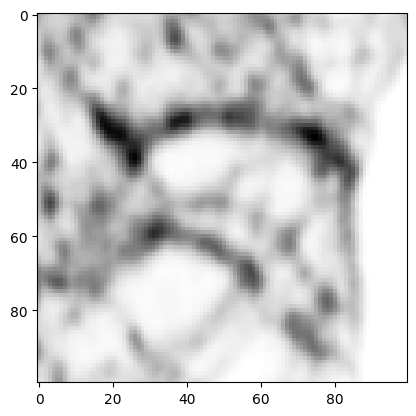

In [138]:
#ROI1 rows: 250 to 350 , columns: 70 to 170
#ROI2 rows: 330:430 , columns: 300:400
#ROI3 rows: 40:140 , columns: 360:460
#ROI4 rows: 285:385, columns: 480:580

roi1_blurred = blurred_image[250:350, 70:170]
roi1_mean_th = mean_th[250:350, 70:170]           # Intensity image
roi1_real_th = real_th[250:350, 70:170]           # G map
roi1_imag_th = imag_th[250:350, 70:170]           # S map

roi2_blurred = blurred_image[330:430, 300:400]
roi2_mean_th = mean_th[330:430, 300:400]
roi2_real_th = real_th[330:430, 300:400]
roi2_imag_th = imag_th[330:430, 300:400]

roi3_blurred = blurred_image[40:140, 360:460]    # V of victory, note used in paper
roi3_mean_th = mean_th[40:140, 360:460]
roi3_real_th = real_th[40:140, 360:460]
roi3_imag_th = imag_th[40:140, 360:460]

roi4_blurred = blurred_image[285:385, 480:580]  # ROI3 in paper
roi4_mean_th = mean_th[285:385, 480:580]
roi4_real_th = real_th[285:385, 480:580]
roi4_imag_th = imag_th[285:385, 480:580]


plt.imshow(roi4_mean_th, cmap = "Grays")
print(roi4_mean_th.shape)

## Phasors from ROIs

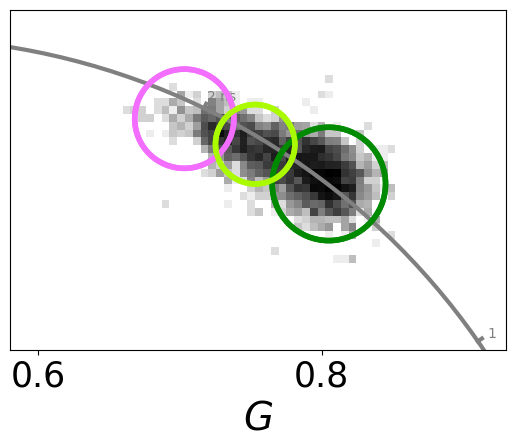

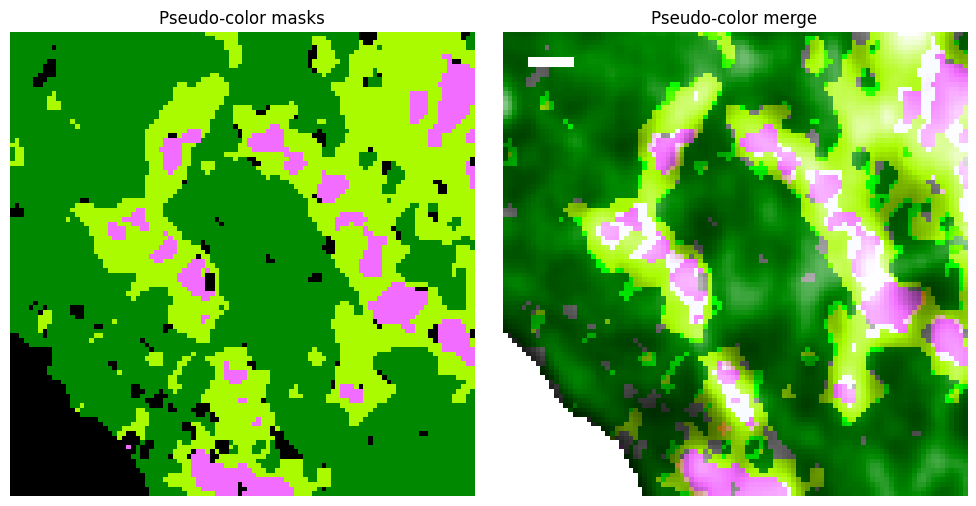

In [139]:
mean_th_zoom = roi1_mean_th  #change the name of the roi to be used, e.g for the roi1 use roi1_...
real_th_zoom = roi1_real_th
imag_th_zoom = roi1_imag_th
intensity = mean_th_zoom

#Cursors for
#ROI1_real [0.804, 0.72, 0.76]
#ROI1_imag [0.397, 0.438, 0.418]
#ROI1_radii [0.033, 0.028, 0.023]
#ROI2_real [0.813, 0.715, 0.762]
#ROI2_imag [0.39, 0.443, 0.418]
#ROI2_radii [0.038, 0.032, 0.025]
#ROI3_real [0.82, 0.735, 0.78]
#ROI3_imag [0.38, 0.43, 0.41]
#ROI3_radii [0.025, 0.025, 0.025]
#ROI4_real [0.805, 0.703, 0.753]
#ROI4_imag [0.397, 0.443, 0.425]
#ROI4_radii [0.04, 0.035, 0.028]

fontsize = 26
labelsize = 28
ticksize = 25
legend_fontsize = 26
lw = 4
#Parameters for scale bar (Change according to the size of the image analyzed)

scalebar_width = 10  # in pixels (54nm/px)
scalebar_height = 2

# Position: bottom left with a 10-pixel margin
               #          80 x 80   100x100    60x60
x_pos = 5     #x_pos :      65       85        45
y_pos = 5     #y_pos :      75       90        55
bar_color = 'white'  # or 'black' depending on your image

              #[green, pink, purple, yellow]
cursors_real = [0.805, 0.703, 0.01, 0.753]    #Write 0.01 in position of purple to skip that color
cursors_imag = [0.397, 0.443, 0.01, 0.425]
radius =       [0.04, 0.035, 0.01, 0.028]

circular_mask = mask_from_circular_cursor(
    real_th_zoom, imag_th_zoom, cursors_real, cursors_imag, radius=radius
)


plot = PhasorPlot(allquadrants=False, title='Phasor plot')
plot.semicircle(frequency, linewidth= 3) # ,color = 'purple')                 #To change the visibility of the semicircle
plot.hist2d(real_th_zoom, imag_th_zoom, cmap='Grays', bins = 200)
plt.xlim(0.58, 0.93)
plt.ylim(0.28, 0.52)
for i in range(len(cursors_real)):
    plot.cursor(
        cursors_real[i],
        cursors_imag[i],
        radius=radius[i],
        #crosshair=True,
        polar=True,
        color=CATEGORICAL[i+2],
        linestyle='-', linewidth = lw
    )
for i in range(len(cursors_real)):
    plot.cursor(
        cursors_real[i],
        cursors_imag[i],
        radius=radius[i],
        color=CATEGORICAL[i+2],
        linestyle='-', linewidth = lw
    )
plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', which='major', labelsize=ticksize) # Adjust labelsize as needed
plt.title('', fontsize = fontsize)
plot.ax.yaxis.set_visible(False)
plot.show()


pseudo_color_masks = pseudo_color(*circular_mask, intensity = None, colors=CATEGORICAL[2:])
pseudo_color_merge = pseudo_color(*circular_mask, intensity = intensity, colors=CATEGORICAL[2:])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

ax1.set_title('Pseudo-color masks')
ax1.imshow(pseudo_color_masks)
ax1.axis('off')

ax2.set_title('Pseudo-color merge')
ax2.imshow(pseudo_color_merge)
ax2.axis('off')

# Add the scale bar
scalebar = patches.Rectangle((x_pos, y_pos), scalebar_width, scalebar_height, linewidth=0, edgecolor=None, facecolor=bar_color)
ax2.add_patch(scalebar)

plt.tight_layout()
plt.show()

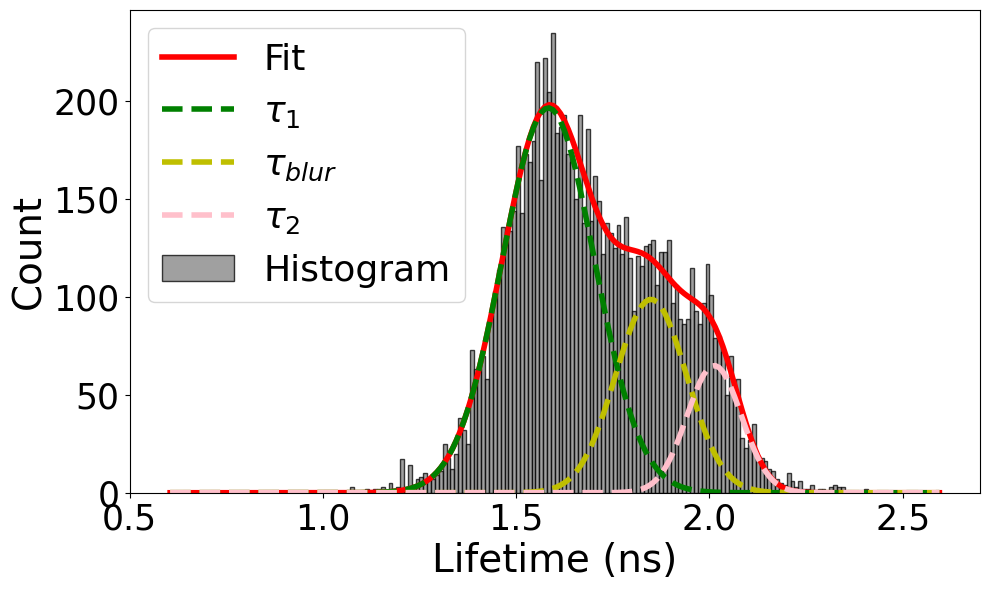

Fitted Parameters for Gaussian 1:
  Amplitude: 196.72
  Mean: 1.58 ns
  Standard Deviation: 0.08 ns

Fitted Parameters for Gaussian 2:
  Amplitude: 98.87
  Mean: 1.85 ns
  Standard Deviation: 0.07 ns

Fitted Parameters for Gaussian 3:
  Amplitude: 65.02
  Mean: 2.01 ns
  Standard Deviation: 0.05 ns


In [140]:
fontsize = 30
labelsize = 28
ticksize = 25
lw = 4
legend_fontsize = 26

phase_lifetime, modulation_lifetime = phasor_to_apparent_lifetime(
    real_th_zoom, imag_th_zoom, frequency
)

# Get the histogram data
hist, bin_edges = np.histogram(np.asarray(modulation_lifetime).flatten(), bins=200, range=(0.6, 2.6))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Initial guesses for the parameters (amplitude, mean, stddev) for each gaussian
# You will need to adjust these based on the visual inspection of your histogram
# These are just placeholders; observe the histogram peaks to make better initial guesses.
# For example, look for the approximate x-values of the peaks and their heights.

# Initial guess parameters for ROIs
#               Amp, Mean, StdDev

# ROI 1     np.max(hist) / 3, 1.65, 0.031,  # Guess for the first peak (adjust mean and stddev)
#           np.max(hist) / 3, 1.9, 0.03,  # Guess for the second peak (adjust mean and stddev)
#           np.max(hist) / 1, 2.1, 0.03

# ROI2 tau_1 = [/3, 0.89, 0.031]
#   tau_blur = [/3, 1.3, 0.012]
#      tau_2 = [/1, 1.5, 0.01 ]

# ROI 4     np.max(hist) / 3, 1.5, 0.03,  # Guess for the first peak (adjust mean and stddev)
#           np.max(hist) / 3, 1.8, 0.03,  # Guess for the second peak (adjust mean and stddev)
#           np.max(hist) / 3, 2.2, 0.03   # Guess for the third peak (adjust mean and stddev)

initial_guess = [
    np.max(hist) / 3, 1.65, 0.031,  # Guess for the first peak (adjust mean and stddev)
    np.max(hist) / 3, 1.9, 0.03,  # Guess for the second peak (adjust mean and stddev)
    np.max(hist) / 3, 2.1, 0.03   # Guess for the third peak (adjust mean and stddev)
]

# Fit the triple gaussian function to the histogram data
try:
    # Bounds for parameters can help the fitting process if you have an idea of the valid range.
    # For example, means should be within the data range, stddevs positive.
    # bounds = ([0, 0.4, 0, 0, 0.4, 0, 0, 0.4, 0], [np.inf, 1.6, np.inf, np.inf, 1.6, np.inf, np.inf, 1.6, np.inf])
    # params, covariance = curve_fit(triple_gaussian, bin_centers, hist, p0=initial_guess, bounds=bounds)

    # Let's try fitting without bounds first, as bounds can sometimes be tricky
    params, covariance = curve_fit(triple_gaussian, bin_centers, hist, p0=initial_guess)


    # Extract the parameters for each gaussian
    amp1, mean1, stddev1, amp2, mean2, stddev2, amp3, mean3, stddev3 = params

    # Generate the fitted curve
    x_fit = np.linspace(bin_centers[0], bin_centers[-1], 200)
    y_fit = triple_gaussian(x_fit, *params)

    # Plot the histogram and the fitted triple gaussian
    plt.figure(figsize=(10, 6))
    plt.bar(bin_centers, hist, width=(bin_edges[1] - bin_edges[0]), color='gray', alpha=0.75, label='Histogram', edgecolor = 'k')
    plt.plot(x_fit, y_fit, color='red', linestyle='-', linewidth=lw, label='Fit')
    plt.plot(x_fit, gaussian(x_fit, amp1, mean1, stddev1), color='green', linestyle='--', linewidth=lw, label=f'$\u03c4_1$')                         #Gaussian 1 (mean={mean1:.2f} ns, std={stddev1:.2f} ns)')
    plt.plot(x_fit, gaussian(x_fit, amp2, mean2, stddev2), color='y', linestyle='--', linewidth=lw, label='$\u03c4_{blur}$')                        #Gaussian 2 (mean={mean2:.2f} ns, std={stddev2:.2f} ns)')
    plt.plot(x_fit, gaussian(x_fit, amp3, mean3, stddev3), color='pink', linestyle='--', linewidth=lw, label=f'$\u03c4_2$')                       #Gaussian 3 (mean={mean3:.2f} ns, std={stddev3:.2f} ns)')

    #plt.title('Apparent Modulation Lifetimes Histogram', fontsize=fontsize)
    plt.xlabel('Lifetime (ns)', fontsize=labelsize)
    plt.ylabel('Count', fontsize=labelsize)
    plt.tick_params(axis='both', which='major', labelsize=ticksize)
    plt.legend(fontsize=legend_fontsize, loc = 2)
    #plt.grid(axis='y', alpha=0.5)
    plt.tight_layout()
    plt.show()

    print("Fitted Parameters for Gaussian 1:")
    print(f"  Amplitude: {amp1:.2f}")
    print(f"  Mean: {mean1:.2f} ns")
    print(f"  Standard Deviation: {stddev1:.2f} ns")

    print("\nFitted Parameters for Gaussian 2:")
    print(f"  Amplitude: {amp2:.2f}")
    print(f"  Mean: {mean2:.2f} ns")
    print(f"  Standard Deviation: {stddev2:.2f} ns")

    print("\nFitted Parameters for Gaussian 3:")
    print(f"  Amplitude: {amp3:.2f}")
    print(f"  Mean: {mean3:.2f} ns")
    print(f"  Standard Deviation: {stddev3:.2f} ns")


except RuntimeError as e:
    print(f"Could not fit the curve: {e}")
    print("Please check your initial guesses or the data.")

## Sharpen ROIs with MSSR

progress: 100%|██████████| 7/7 [00:00<00:00, 1089.39it/s]


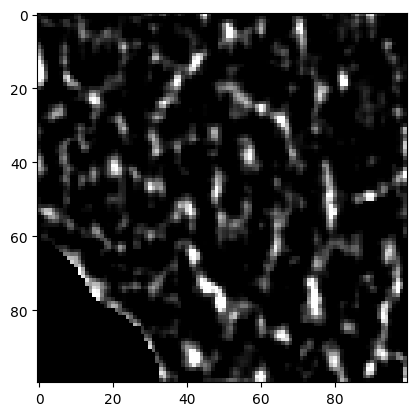

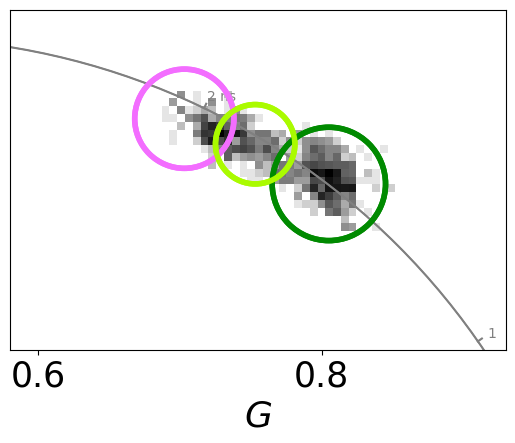

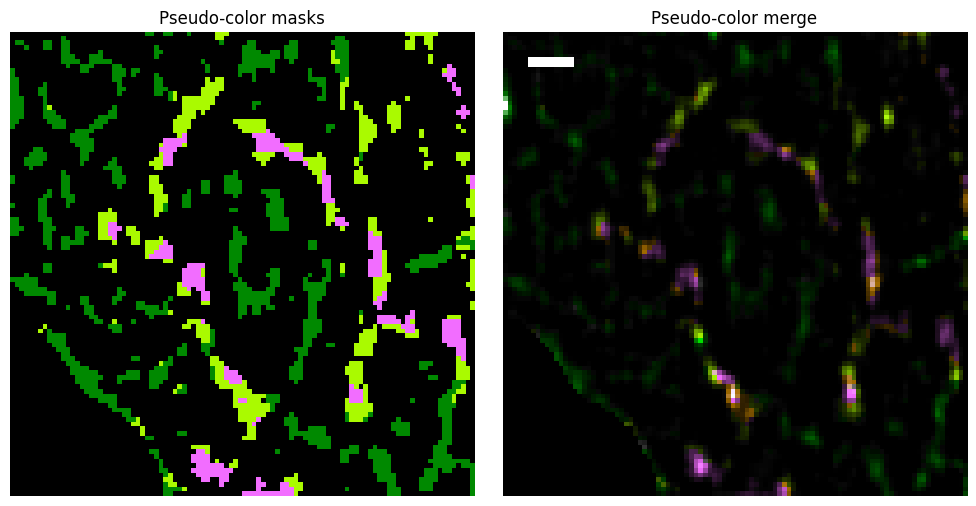

In [141]:
#Apply MSSR1

mean_mssr1_zoom = mssr_instance.sfMSSR(img=mean_th_zoom, fwhm=fwhm, amp=amp, order=order, mesh=mesh, ftI=ftI, intNorm=intNorm)
intensity = mean_mssr1_zoom

plt.imshow(mean_mssr1_zoom, cmap='gray', vmin=0, vmax=0.25)

#Parameters for scale bar (Change according to the size of the image analyzed)

fontsize = 24
labelsize = 26
ticksize = 25
lw = 4

scalebar_width = 10  # in pixels
scalebar_height = 2
# Position: bottom left with a 10-pixel margin
x_pos = 5
y_pos = 5
bar_color = 'white'  # or 'black' depending on your image

## Threshold
mean_th_mssr1_zoom, real_th_mssr1_zoom, imag_th_mssr1_zoom = phasor_threshold(mean_mssr1_zoom, real_th_zoom, imag_th_zoom, mean_min=0.04)

## Masks from phasors

circular_mask = mask_from_circular_cursor(
    real_th_mssr1_zoom, imag_th_mssr1_zoom, cursors_real, cursors_imag, radius=radius
)


plot = PhasorPlot(allquadrants=False, title='Phasor plot')
plot.semicircle(frequency=frequency, linewidth= 1.5)
plot.hist2d(real_th_mssr1_zoom, imag_th_mssr1_zoom, cmap='Greys', bins= 200)
plt.xlim(0.58, 0.93)
plt.ylim(0.28, 0.52)
for i in range(len(cursors_real)):
    plot.cursor(
        cursors_real[i],
        cursors_imag[i],
        radius=radius[i],
        #crosshair=True,
        polar=True,
        color=CATEGORICAL[i+2],
        linestyle='-', linewidth = lw
    )
for i in range(len(cursors_real)):
    plot.cursor(
        cursors_real[i],
        cursors_imag[i],
        radius=radius[i],
        #crosshair=True,
        color=CATEGORICAL[i+2],
        linestyle='-', linewidth = lw
    )
plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', which='major', labelsize=ticksize) # Adjust labelsize as needed
plt.title('', fontsize = fontsize) #Phasor plot with circular cursors
plot.ax.yaxis.set_visible(False)
plot.show()


pseudo_color_masks = pseudo_color(*circular_mask, intensity = None, colors=CATEGORICAL[2:])
pseudo_color_merge = pseudo_color(*circular_mask, intensity = intensity, colors=CATEGORICAL[2:])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

ax1.set_title('Pseudo-color masks')
ax1.imshow(pseudo_color_masks)
ax1.axis('off')

ax2.set_title('Pseudo-color merge')
ax2.imshow(pseudo_color_merge)
ax2.axis('off')

# Add the scale bar
scalebar = patches.Rectangle((x_pos, y_pos), scalebar_width, scalebar_height,
                             linewidth=0, edgecolor=None, facecolor=bar_color)
ax2.add_patch(scalebar)

plt.tight_layout()
plt.show()


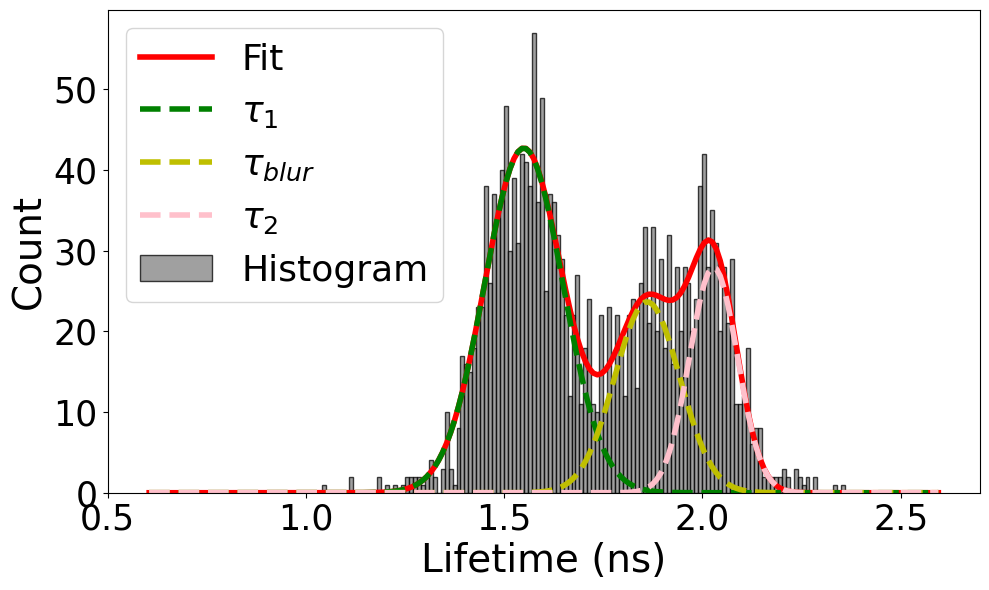

Fitted Parameters for Gaussian 1:
  Amplitude: 42.73
  Mean: 1.55 ns
  Standard Deviation: 0.07 ns

Fitted Parameters for Gaussian 2:
  Amplitude: 23.67
  Mean: 1.86 ns
  Standard Deviation: 0.06 ns

Fitted Parameters for Gaussian 3:
  Amplitude: 27.96
  Mean: 2.03 ns
  Standard Deviation: 0.04 ns


In [142]:
fontsize = 30
labelsize = 28
ticksize = 25
lw = 4
legend_fontsize = 26

phase_lifetime, modulation_lifetime = phasor_to_apparent_lifetime(
    real_th_mssr1_zoom, imag_th_mssr1_zoom, frequency
)

# Get the histogram data
hist, bin_edges = np.histogram(np.asarray(modulation_lifetime).flatten(), bins=200, range=(0.6, 2.6))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Initial guesses for the parameters (amplitude, mean, stddev) for each gaussian
# You will need to adjust these based on the visual inspection of your histogram
# These are just placeholders; observe the histogram peaks to make better initial guesses.
# For example, look for the approximate x-values of the peaks and their heights.

#Initial guesses for ROI 1
#  initial_guess = [
#     np.max(hist) / 3, 1.65, 0.031,  # Guess for the first peak (adjust mean and stddev)
#     np.max(hist) / 3, 1.8, 0.03,  # Guess for the second peak (adjust mean and stddev)
#     np.max(hist) / 3, 2.0, 0.03   # Guess for the third peak (adjust mean and stddev)
#  ]


initial_guess = [
    np.max(hist) / 3, 1.65, 0.031,  # Guess for the first peak (adjust mean and stddev)
    np.max(hist) / 3, 1.8, 0.03,  # Guess for the second peak (adjust mean and stddev)
    np.max(hist) / 2, 2.0, 0.03   # Guess for the third peak (adjust mean and stddev)
]

# Fit the triple gaussian function to the histogram data
try:
    # Bounds for parameters can help the fitting process if you have an idea of the valid range.
    # For example, means should be within the data range, stddevs positive.
    # bounds = ([0, 0.4, 0, 0, 0.4, 0, 0, 0.4, 0], [np.inf, 1.6, np.inf, np.inf, 1.6, np.inf, np.inf, 1.6, np.inf])
    # params, covariance = curve_fit(triple_gaussian, bin_centers, hist, p0=initial_guess, bounds=bounds)

    # Let's try fitting without bounds first, as bounds can sometimes be tricky
    params, covariance = curve_fit(triple_gaussian, bin_centers, hist, p0=initial_guess)


    # Extract the parameters for each gaussian
    amp1, mean1, stddev1, amp2, mean2, stddev2, amp3, mean3, stddev3 = params

    # Generate the fitted curve
    x_fit = np.linspace(bin_centers[0], bin_centers[-1], 200)
    y_fit = triple_gaussian(x_fit, *params)

    # Plot the histogram and the fitted triple gaussian
    plt.figure(figsize=(10, 6))
    plt.bar(bin_centers, hist, width=(bin_edges[1] - bin_edges[0]), color='gray', alpha=0.75, label='Histogram', edgecolor = 'k')
    plt.plot(x_fit, y_fit, color='red', linestyle='-', linewidth=lw, label='Fit')
    plt.plot(x_fit, gaussian(x_fit, amp1, mean1, stddev1), color='green', linestyle='--', linewidth=lw, label=f'$\u03c4_1$')                         #Gaussian 1 (mean={mean1:.2f} ns, std={stddev1:.2f} ns)')
    plt.plot(x_fit, gaussian(x_fit, amp2, mean2, stddev2), color='y', linestyle='--', linewidth=lw, label='$\u03c4_{blur}$')                        #Gaussian 2 (mean={mean2:.2f} ns, std={stddev2:.2f} ns)')
    plt.plot(x_fit, gaussian(x_fit, amp3, mean3, stddev3), color='pink', linestyle='--', linewidth=lw, label=f'$\u03c4_2$')                       #Gaussian 3 (mean={mean3:.2f} ns, std={stddev3:.2f} ns)')

    #plt.title('Apparent Modulation Lifetimes Histogram', fontsize=fontsize)
    plt.xlabel('Lifetime (ns)', fontsize=labelsize)
    plt.ylabel('Count', fontsize=labelsize)
    plt.tick_params(axis='both', which='major', labelsize=ticksize)
    plt.legend(fontsize=legend_fontsize, loc = 2)
    #plt.grid(axis='y', alpha=0.5)
    plt.tight_layout()
    plt.show()

    print("Fitted Parameters for Gaussian 1:")
    print(f"  Amplitude: {amp1:.2f}")
    print(f"  Mean: {mean1:.2f} ns")
    print(f"  Standard Deviation: {stddev1:.2f} ns")

    print("\nFitted Parameters for Gaussian 2:")
    print(f"  Amplitude: {amp2:.2f}")
    print(f"  Mean: {mean2:.2f} ns")
    print(f"  Standard Deviation: {stddev2:.2f} ns")

    print("\nFitted Parameters for Gaussian 3:")
    print(f"  Amplitude: {amp3:.2f}")
    print(f"  Mean: {mean3:.2f} ns")
    print(f"  Standard Deviation: {stddev3:.2f} ns")


except RuntimeError as e:
    print(f"Could not fit the curve: {e}")
    print("Please check your initial guesses or the data.")

# Lifetime maps

In [143]:
## Funtion to calculate the modulation and phase


def mode_and_phase(G,S,laser_period_in_seconds, harmonic = 1, colour = 'PRGn'):
    from matplotlib.ticker import FormatStrFormatter
    import matplotlib.cm as cm
    # A function to calculate the modulation, phase delay
    T = laser_period_in_seconds
    T_nano = T*1e9          #to show in nanoseconds
    n = harmonic # number of harmonic (default 1)
    w = (2 * np.pi * n) / T
    w_nano = (2 * np.pi) / T_nano
    # Setting epsilon to avoid division by zero
    #epsilon = np.nan

    #G = np.where(G > 0, G, epsilon)
    #S = np.where(S > 0, S, epsilon)

    mod = np.sqrt(G**2 + S**2)
    phi = np.arctan2(S,G)

    #mod_min = np.min(mod)
    #mod_max = np.max(mod)

    phi_max = np.max(phi)
    phi_min = np.min(phi)

    #Phase correction
    quarter_pi = np.arctan(1)
    phi[phi==quarter_pi] = 0

    #Output figure

    titlesize = 18
    suptitle = 20
    axsize = 18
    ticksize = 18

    # Create a colormap that sets NaNs to black
    cmap = plt.colormaps.get_cmap(colour).copy()
    cmap.set_bad(color='black')

    ##Images of TD_FLIM and the phasor plot
    f, ax = plt.subplots(1,2, figsize = (14,6)) #(7,4.5)

    #Modulation Map
    im00 = ax[0].imshow(mod, cmap=cmap)
    ax[0].axis('off')
    ax[0].set_title('Modulation Map', fontsize=titlesize)
    cbar00 = f.colorbar(im00, ax = ax[0], fraction=0.046, pad=0.04)
    cbar00.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    cbar00.set_label('Modulation [a.u.]', fontsize=axsize)
    cbar00.ax.tick_params(labelsize=ticksize)  # Adjust tick label size
    #ax[0].legend(bbox_to_anchor=(1.5, -0.2), loc='lower center', ncol=2, fontsize = ticksize) #-0.2
    #ax[0,0].set_box_aspect(1)

    #Phase Map
    im01 = ax[1].imshow(phi, cmap=cmap)
    ax[1].axis('off')
    ax[1].set_title('Phase Map', fontsize=titlesize)
    cbar01 = f.colorbar(im01, ax = ax[1], fraction=0.046, pad=0.04)
    cbar01.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    cbar01.set_label('Phase angle [rad]', fontsize=axsize)
    cbar01.ax.tick_params(labelsize=ticksize)  # Adjust tick label size
    #ax[0,1].set_box_aspect(1)

    f.suptitle('Modulation and Phase maps',x=0.5, y=0.99, fontsize = suptitle)
    f.subplots_adjust(wspace=0.3, hspace=0.3, top=0.9, bottom=0.1, left=0.05, right=0.95)
    plt.show()

    return mod, phi, f

## Function to calculate the lifetime maps

def lifetime_maps(G, S, laser_period_in_seconds, harmonic=1, colour='PRGn'):
    from matplotlib.ticker import FormatStrFormatter
    import matplotlib.cm as cm
    """
    Compute and plot modulation and phase lifetime maps side-by-side.

    Parameters:
    G, S : 2D arrays
        G and S phasor components.
    laser_period_in_seconds : float
        Laser repetition period in seconds.
    harmonic : int, optional
        Harmonic number (default is 1).
    colour : str, optional
        Name of matplotlib colormap to use.

    Returns:
    tau_m, tau_p : 2D arrays
        Modulation and phase lifetime maps in nanoseconds.
    fig : matplotlib.figure.Figure
        The generated figure.
    """
    # Constants
    T = laser_period_in_seconds
    T_nano = T * 1e9
    n = harmonic
    w = (2 * np.pi * n) / T
    w_nano = (2 * np.pi * n) / T_nano

    # Lifetime calculations
    mod = np.sqrt(G**2 + S**2)
    tau_m = (1 / w) * np.sqrt(np.maximum((1 / (mod**2)) - 1, 0)) * 1e9  # ns
    tau_p = (1 / w) * (S / G) * 1e9  # ns

    # Create colormap with NaNs as black
    cmap = cm.get_cmap(colour).copy()
    cmap.set_bad(color='black')

    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(14,6))

    im0 = axs[0].imshow(tau_m, cmap=cmap)
    axs[0].set_title('Modulation Lifetime', fontsize=18)
    axs[0].axis('off')
    cbar0 = plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
    cbar0.set_label('[ns]', fontsize=18)
    cbar0.ax.tick_params(labelsize=20)

    im1 = axs[1].imshow(tau_p, cmap=cmap)
    #axs[1].set_title('Phase Lifetime', fontsize=18)
    axs[1].axis('off')
    cbar1 = plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
    cbar1.set_label('[ns]', fontsize=18)
    cbar1.ax.tick_params(labelsize=20)

    fig.suptitle('Lifetime maps',x=0.5, y=0.99, fontsize = 20)

    plt.tight_layout()
    plt.show()

    return tau_m, tau_p, fig

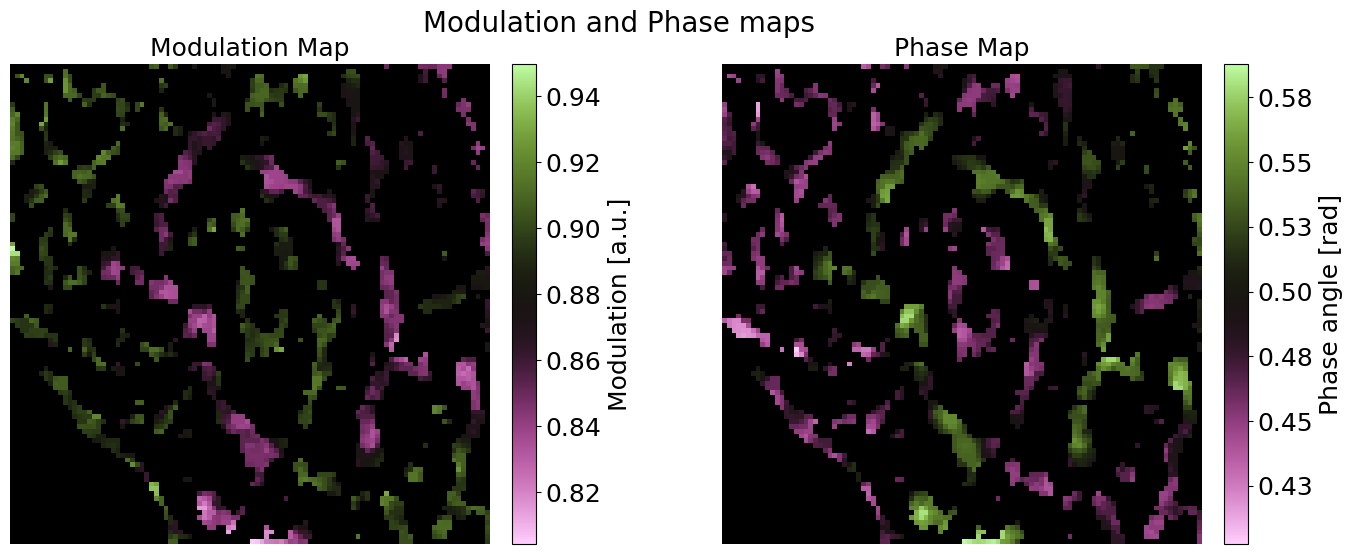

/tmp/ipython-input-4113060301.py:110: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colour).copy()


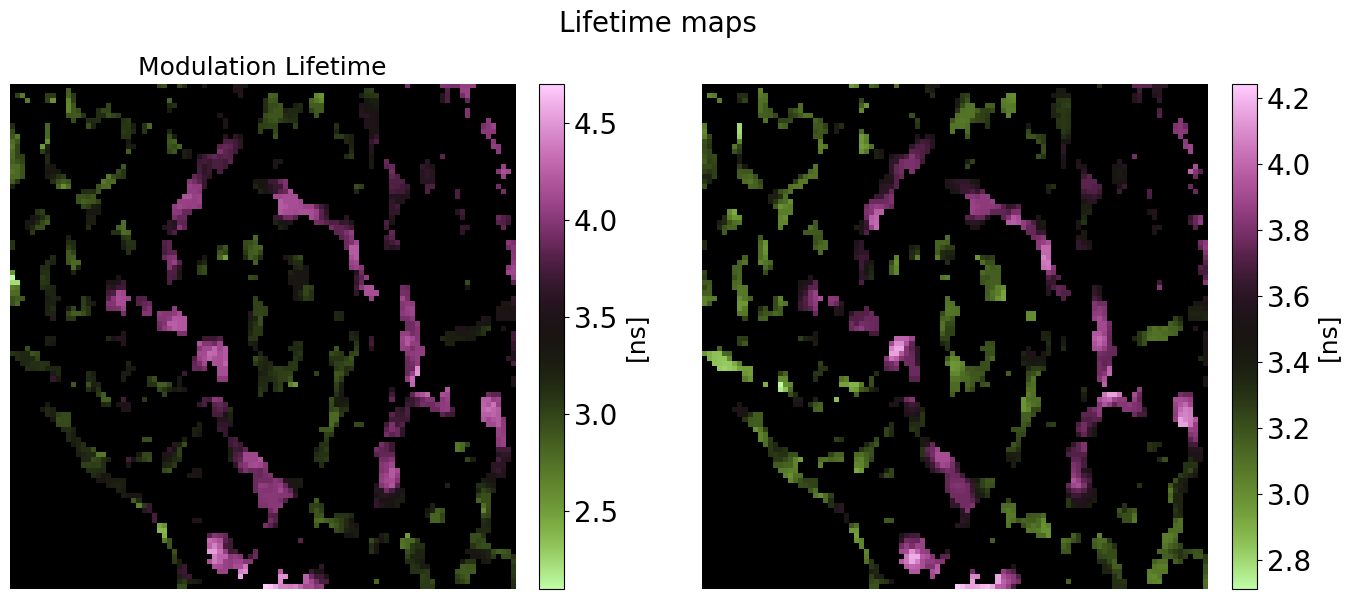

In [144]:
import cmcrameri.cm as cmc

# Parameters


# Parameters for TD-FLIM figure
T = (1 / frequency) * 1e3
T_nano = T*1e9
laser_period_in_seconds = T * 1e-9

color_1 = 'cmc.vanimo'
color_2 = 'cmc.vanimo_r'

mean_th_mssr1, real_th_mssr1, imag_th_mssr1

#Modulation and Phase
mod, phase, f_mod_phi = mode_and_phase(real_th_mssr1_zoom,imag_th_mssr1_zoom,laser_period_in_seconds, harmonic = 1, colour = color_1)

# Lifetime maps
tau_m, tau_p, fig = lifetime_maps(real_th_mssr1_zoom, imag_th_mssr1_zoom,laser_period_in_seconds, harmonic = 0.5, colour = color_2)

## Save Intensity image as TIF

In [145]:
from google.colab import files

# Save the intensity image as a TIFF file
output_image_path = "/content/drive/MyDrive/2025/MSSR-FLIM/Data/2CGQ_Intensity_image.tif"
tifffile.imwrite(output_image_path, image)

# Provide a download link for the saved image
files.download(output_image_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Multicomponent Analysis on Whole Cell

In [146]:
import math

from phasorpy.component import (
    phasor_component_fit,
    phasor_component_fraction,
    phasor_component_graphical,
)

np.random.seed(42)
component_style = {
    'linestyle': '-',
    'linewidth': 3,
    'marker': 'o',
    'color': 'purple',
    'fontsize': 16,
}

## 2 Component Analysis

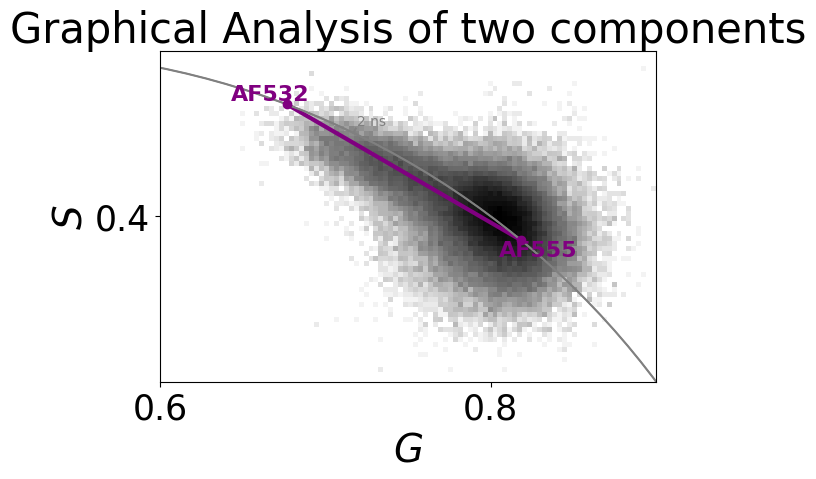

In [147]:
component_lifetimes = [1.5, 2.2]
component_real, component_imag = phasor_from_lifetime(
    frequency, component_lifetimes
)

plot = PhasorPlot(
    xlim=(0.6, 0.9), ylim=(0.3, 0.5), allquadrants=False)
plot.semicircle(frequency=frequency, linewidth= 1.5)

plot.hist2d(real_th, imag_th, cmap='Greys', bins = 100)
#plot.contour(real_th, imag_th, bins=100, cmap='summer_r', norm='log')
plot.components(
    component_real, component_imag, labels=['AF555', 'AF532'], **component_style
)

plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
plt.title('Graphical Analysis of two components', fontsize = fontsize)
plot.show()

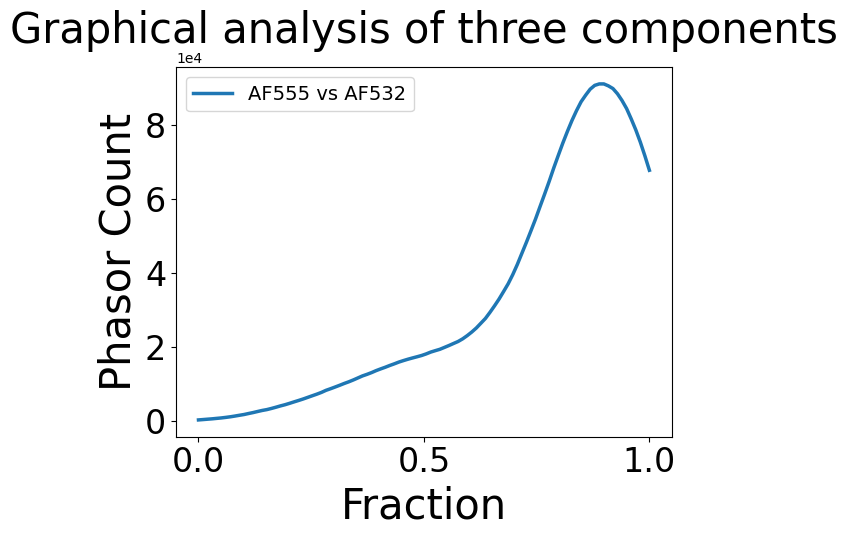

In [148]:
lw = 2.5
legendsize = 14
ticksize = 24
rad = 0.02
fractions = np.linspace(0.0, 1.0, 100)

fraction_of_first_component = phasor_component_fraction(
    real_th, imag_th, component_real, component_imag
)

counts = phasor_component_graphical(
    real_th,
    imag_th,
    component_real,
    component_imag,
    fractions=fractions,
    radius=rad,
)

count_2 = 1 - fraction_of_first_component

fig, ax = plt.subplots()

ax.plot(fractions, counts, '-', label='AF555 vs AF532', linewidth = lw)
ax.set_title('Graphical analysis of three components', fontsize = fontsize)
ax.set_xlabel('Fraction', fontsize = fontsize)
ax.set_ylabel('Phasor Count', fontsize = fontsize)
ax.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0)) # Format y-axis ticks as scientific notation
ax.legend(fontsize = legendsize)
plt.show()

## Histograms of 2 component fractions

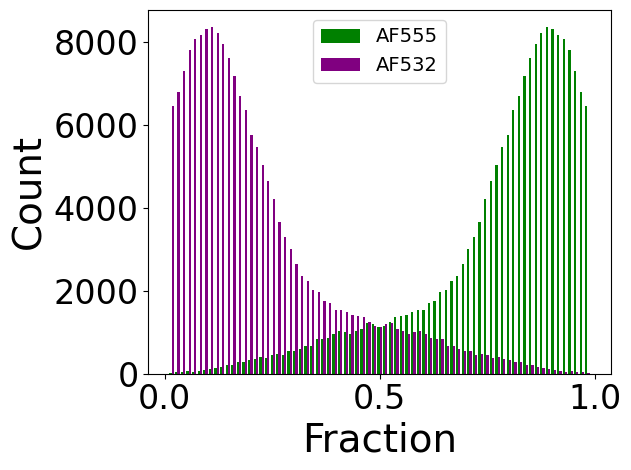

In [149]:
plot_histograms(
    fraction_of_first_component,
    1.0 - fraction_of_first_component,
    range=(0.01, 0.99),
    bins=75,
    #alpha=0.66,
    labels=['AF555', 'AF532'],
    xlabel='Fraction',
    ylabel='Count',
    #title='Histograms of fractions of two components',
    color=['g','purple'],
    title_fontsize= fontsize,
    label_fontsize = labelsize,
    tick_labelsize = ticksize
)

## Principal Component Analysis

## 3-Component Analysis

### Harmonic Transform

In [150]:
def phasor_harmonic_transform(g_matrix, s_matrix, harmonic=1):
    """
    Transform phasor (g,s) values from fundamental frequency
    to another harmonic.

    Parameters
    ----------
    g_matrix : np.ndarray
        Matrix of real (G) phasor values at fundamental frequency.
    s_matrix : np.ndarray
        Matrix of imaginary (S) phasor values at fundamental frequency.
    harmonic : int, optional
        Harmonic number to transform to (default=1, i.e., no change).

    Returns
    -------
    g_harmonic : np.ndarray
        Transformed real (G) values at chosen harmonic.
    s_harmonic : np.ndarray
        Transformed imaginary (S) values at chosen harmonic.
    """

    # Build complex phasor
    z = g_matrix + 1j * s_matrix

    # Raise to chosen harmonic
    z_harmonic = np.power(z, harmonic)

    # Separate into real and imaginary parts
    g_harmonic = np.real(z_harmonic)
    s_harmonic = np.imag(z_harmonic)

    return g_harmonic, s_harmonic

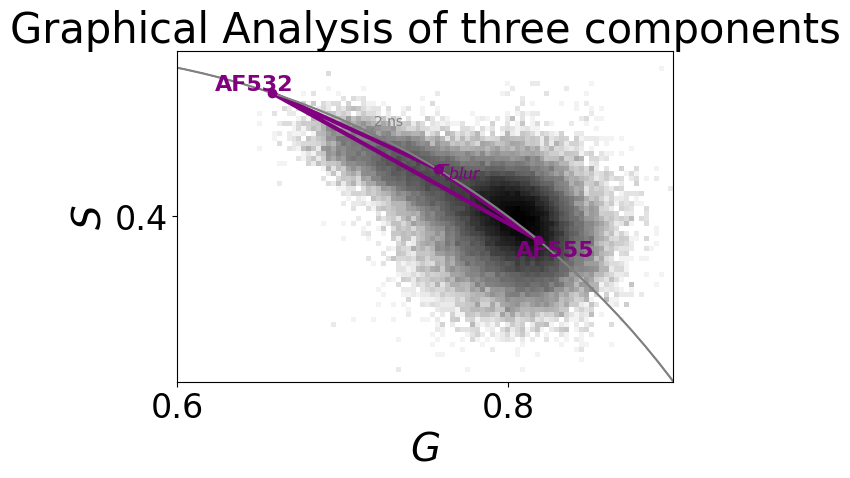

In [151]:
component_lifetimes = [1.8, 2.3, 1.5] #In order [tau_blur, AF532, AF555]
component_real, component_imag = phasor_from_lifetime(
    frequency, component_lifetimes
)

plot = PhasorPlot(
    xlim=(0.6, 0.9), ylim=(0.3, 0.5), allquadrants=False)
plot.semicircle(frequency=frequency, linewidth= 1.5)

plot.hist2d(real_th, imag_th, cmap='Greys', bins = 100)
#plot.contour(real_th, imag_th, bins=100, cmap='summer_r', norm='log')
plot.components(
    component_real, component_imag, labels=['$\u03c4_{blur}$', 'AF532', 'AF555'], **component_style
)

plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
plt.title('Graphical Analysis of three components', fontsize = fontsize)
plot.show()

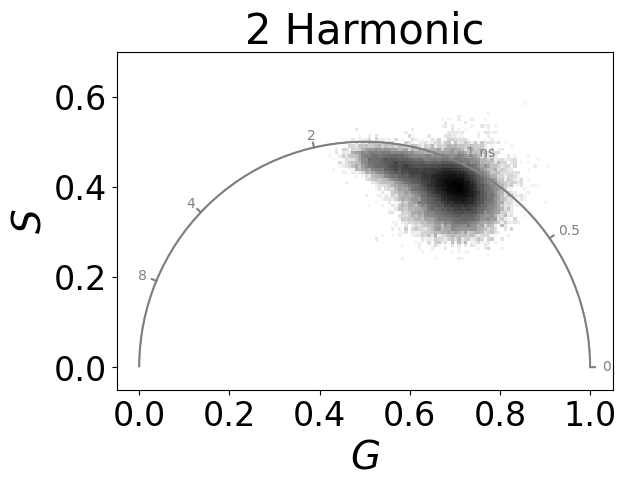

In [152]:
# Calculate the phasor components at the n-th harmonic
n = 2 # number of harmonic
real_th_2, imag_th_2 = phasor_harmonic_transform(real_th, imag_th, harmonic=n)

# Calibration of the 2nd harmonic

n_freq = frequency*n
reference_lifetime = 4.1

settings = {
    'samples': 256,  # number of samples to synthesize
    'mean': 10,  # average intensity
    'background': 0,  # no signal from background
    'zero_phase': 0.4,  # location of IRF peak in the phase, where the decimal should increase when increasing the n
    'zero_stdev': None,  # standard deviation of IRF in radians
}

reference_signal, _, _ = lifetime_to_signal(n_freq, reference_lifetime, **settings)

x_dim = real_th.shape[0]
y_dim = real_th.shape[1]
t_dim = settings['samples'] # Set t_dim to match the number of samples

# Create an image stack with the reference signal
img_reference_signal = np.zeros((t_dim, x_dim, y_dim))
# Assuming the signal should be the same for all pixels in the reference image
for i in range(x_dim):
  for j in range(y_dim):
    img_reference_signal[:, i, j] = reference_signal

# Calibration
reference_mean, reference_real, reference_imag = phasor_from_signal(
    img_reference_signal, axis=0
)

n_real, n_imag = phasor_calibrate(
    real_th_2,
    imag_th_2,
    reference_mean,
    reference_real,
    reference_imag,
    frequency=n_freq,
    lifetime=reference_lifetime,
)

# Plotting the nth- harmonic phasor

plot = PhasorPlot(allquadrants=False, title=f'{n} Harmonic')
plot.hist2d(n_real, n_imag, cmap='Greys', bins = 150)
plot.semicircle(frequency*n, linewidth= 1.5)
plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
plt.title(f'{n} Harmonic', fontsize = fontsize)

plt.show()

### Comparing the Principal Harmonic with the n-th Harmonic

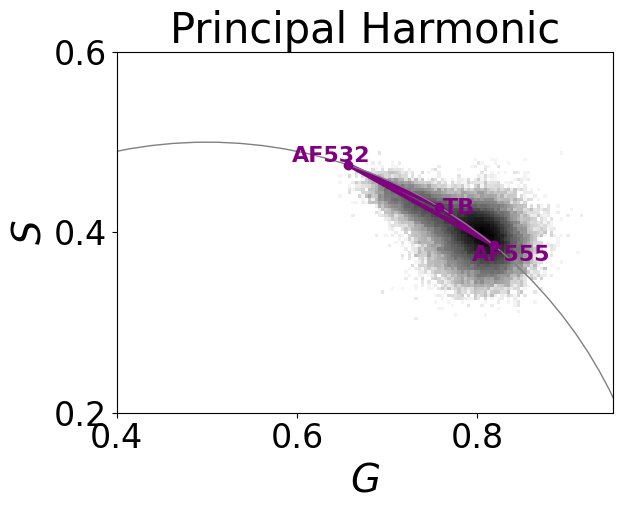

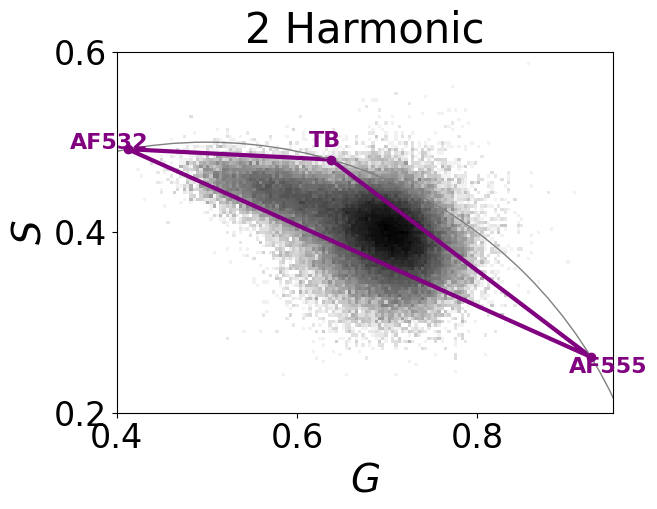

In [153]:
plot = PhasorPlot(xlim=(0.4, 0.95), ylim=(0.2, 0.6), allquadrants=False, title='Principal Harmonic')
plot.hist2d(real_th, imag_th, cmap='Greys', bins = 150)
#plot.semicircle(frequency, linewidth= 1.5)
#plot.contour(real_th, imag_th, bins=50, levels=18, cmap='summer_r', norm='log')
plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
plt.title('Principal Harmonic', fontsize = fontsize)

#3 component analysis
plot.components(
    component_real, component_imag, labels=['TB','AF532', 'AF555'], **component_style
)

plot.show()

plot = PhasorPlot(xlim=(0.4, 0.95), ylim=(0.2, 0.6), allquadrants=False, title=f'{n} Harmonic')
plot.hist2d(n_real,n_imag, cmap='Greys', bins = 150)
#plot.semicircle(frequency*n, linewidth= 1.5)
#plot.contour(n_real, n_imag, bins=50, levels=18, cmap='summer_r', norm='log')
plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
plt.title(f'{n} Harmonic', fontsize = fontsize)

#3 component analysis
component_lifetimes_nharm = [1.2, 1.9, 0.45] #In order [tau_blur, AF532, AF555]
component_real_n, component_imag_n = phasor_from_lifetime(
    frequency*n, component_lifetimes_nharm
)
plot.components(
    component_real_n, component_imag_n, labels=['TB', 'AF532', 'AF555'], **component_style
)

plot.show()

## Multicomponent Analysis

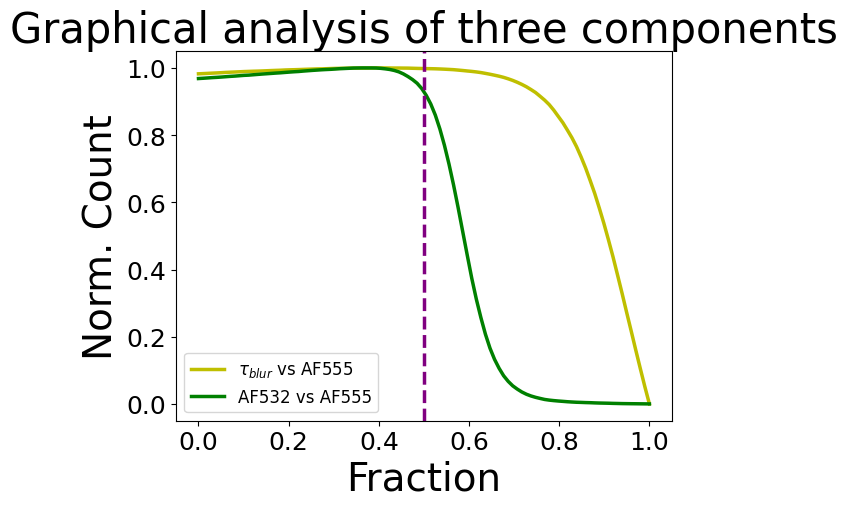

In [154]:
legend_fontsize = 12

rad = 0.09
fractions = np.linspace(0.0, 1.0, 100)
counts = phasor_component_graphical(
    n_real,
    n_imag,
    component_real_n,
    component_imag_n,
    fractions=fractions,
    radius=rad,
)

normcounts_0 = (counts[0] - np.min(counts[0])) / (np.max(counts[0]) - np.min(counts[0]))
normcounts_1 = (counts[1] - np.min(counts[1])) / (np.max(counts[1]) - np.min(counts[1]))
normcounts_2 = (counts[2] - np.min(counts[2])) / (np.max(counts[2]) - np.min(counts[2]))

fig, ax = plt.subplots()
#ax.plot(fractions, normcounts_0, '-', label='$\u03c4_{blur}$ vs AF532', linewidth = lw, color = 'y')
ax.plot(fractions, normcounts_1, '-', label='$\u03c4_{blur}$ vs AF555', linewidth = lw, color = 'y' )
ax.plot(fractions, normcounts_2, '-', label='AF532 vs AF555', linewidth = lw, color = 'g')
ax.set_title('Graphical analysis of three components', fontsize = fontsize)
ax.set_xlabel('Fraction', fontsize = labelsize)
ax.set_ylabel('Norm. Count', fontsize = labelsize)
ax.tick_params(axis='both', labelsize=18) # Adjust labelsize as needed  which='major'
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0)) # Format y-axis ticks as scientific notation
ax.axvline(0.5, linestyle = '--', linewidth = 2.5, color = 'purple')
ax.legend(fontsize = legend_fontsize)
plt.show()

### Multicomponent Analysis After MSSR

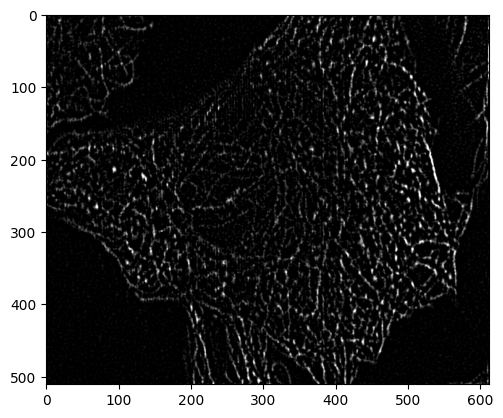

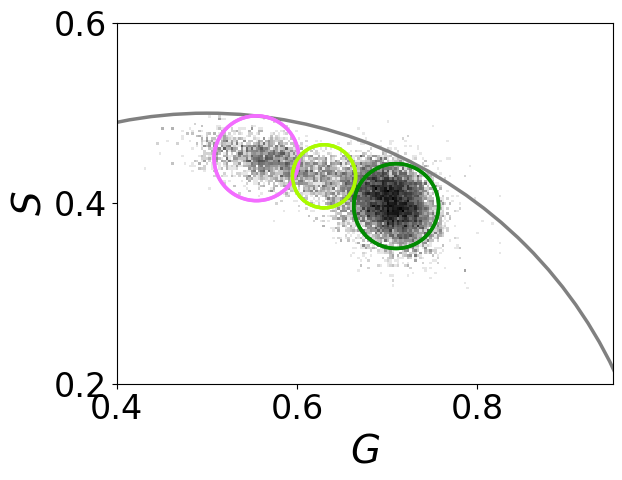

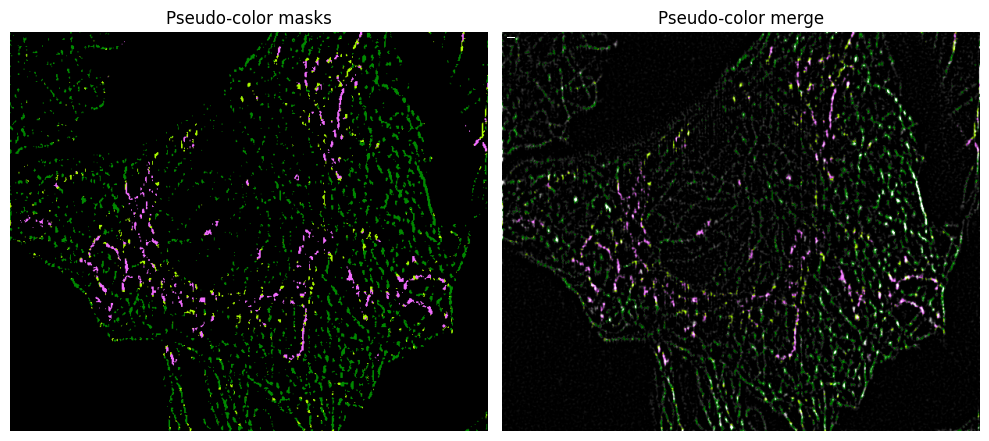

In [155]:
# Apply MSSR mask to the 2nd Harmonic G/S matrices
# At this point MSSR1 was alreadey done to the intensity based image, we are going to called that mask again to mask for the G/S 2nd harmonic matrices
# mean_mssr1

intensity = mean_mssr1

plt.imshow(intensity, cmap='gray', vmin=0, vmax=0.25)

## Threshold
n_mean_mssr, n_real_mssr, n_imag_mssr = phasor_threshold(intensity, n_real, n_imag, mean_min=0.05)

cursors_real = [0.71, 0.555, 0.01, 0.63]      # cursors_real = [0.82, 0.7, 0.755]
cursors_imag = [0.397, 0.45, 0.01, 0.43]      # cursors_imag = [0.39, 0.445, 0.42]
radius = [0.047, 0.047, 0.01, 0.035]           # radius = [0.04, 0.03, 0.03]

#circular cursor to the MSSR thresholded G/S 2nd harmonic matrices
circular_mask = mask_from_circular_cursor(
    n_real_mssr, n_imag_mssr, cursors_real, cursors_imag, radius=radius
)


plot = PhasorPlot(xlim = (0.4, 0.95), ylim=(0.2, 0.6), allquadrants=False, title='Phasor Plot')
plot.semicircle(linewidth= 2.5)
plot.hist2d(n_real_mssr, n_imag_mssr, cmap='Grays', bins = 200)
for i in range(len(cursors_real)):
    plot.cursor(
        cursors_real[i],
        cursors_imag[i],
        radius=radius[i],
        #crosshair=True,
        polar=True,
        color=CATEGORICAL[i+2],
        linestyle='-', linewidth = lw
    )
for i in range(len(cursors_real)):
    plot.cursor(
        cursors_real[i],
        cursors_imag[i],
        radius=radius[i],
        #crosshair=True,
        color=CATEGORICAL[i+2],
        linestyle='-', linewidth = lw
    )
plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', which='major', labelsize=ticksize) # Adjust labelsize as needed
plt.title('', fontsize = fontsize)
plot.show()


pseudo_color_masks = pseudo_color(*circular_mask, intensity = None, colors=CATEGORICAL[2:])
pseudo_color_merge = pseudo_color(*circular_mask, intensity = intensity, colors=CATEGORICAL[2:], vmin=0, vmax=0.25)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

ax1.set_title('Pseudo-color masks')
ax1.imshow(pseudo_color_masks)
ax1.axis('off')

ax2.set_title('Pseudo-color merge')
ax2.imshow(pseudo_color_merge)
ax2.axis('off')

# Add the scale bar
scalebar = patches.Rectangle((x_pos, y_pos), scalebar_width, scalebar_height,
                             linewidth=0, edgecolor=None, facecolor=bar_color)
ax2.add_patch(scalebar)

plt.tight_layout()
plt.show()

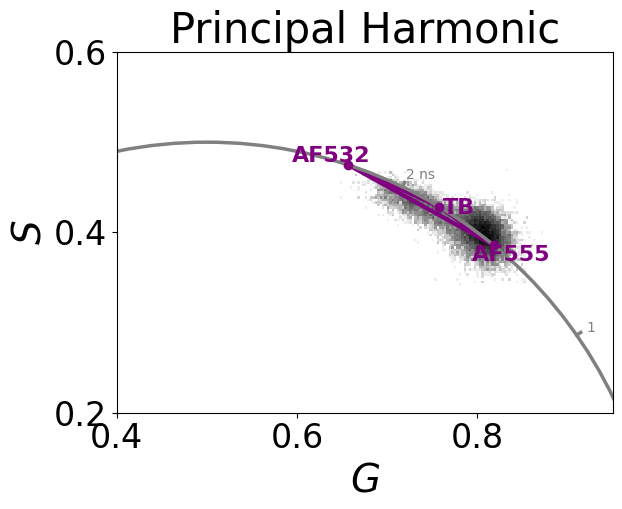

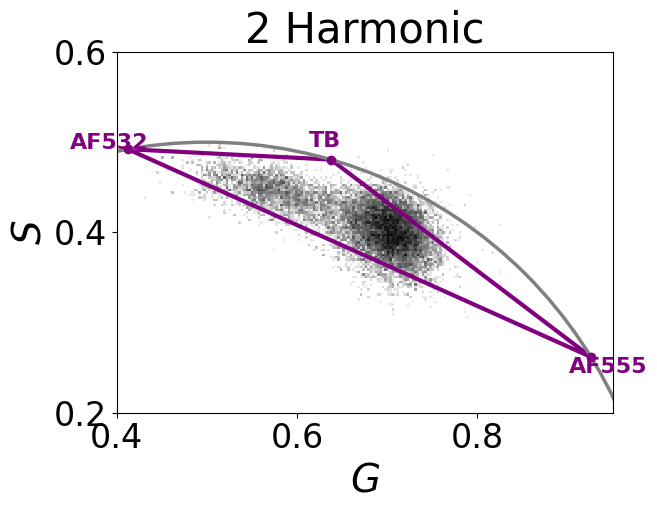

In [156]:
plot = PhasorPlot(xlim=(0.4, 0.95), ylim=(0.2, 0.6), allquadrants=False, title='Principal Harmonic')
plot.hist2d(real_th_mssr1, imag_th_mssr1, cmap='Greys', bins = 200)
plot.semicircle(frequency, linewidth= 2.5)
#plot.contour(real_th, imag_th, bins=50, levels=18, cmap='summer_r', norm='log')
plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
plt.title('Principal Harmonic', fontsize = fontsize)

#3 component analysis
plot.components(
    component_real, component_imag, labels=['TB','AF532', 'AF555'], **component_style
)

plot.show()

plot = PhasorPlot(xlim=(0.4, 0.95), ylim=(0.2, 0.6), allquadrants=False, title=f'{n} Harmonic')
plot.hist2d(n_real_mssr, n_imag_mssr, cmap='Greys', bins = 200)
plot.semicircle(linewidth= 2.5)
#plot.contour(n_real, n_imag, bins=50, levels=18, cmap='summer_r', norm='log')
plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
plt.title(f'{n} Harmonic', fontsize = fontsize)

#3 component analysis
component_lifetimes_nharm = [1.2, 1.9, 0.45] #In order [tau_blur, AF532, AF555]
component_real_n, component_imag_n = phasor_from_lifetime(
    n_freq, component_lifetimes_nharm
)
plot.components(
    component_real_n, component_imag_n, labels=['TB', 'AF532', 'AF555'], **component_style
)

plot.show()

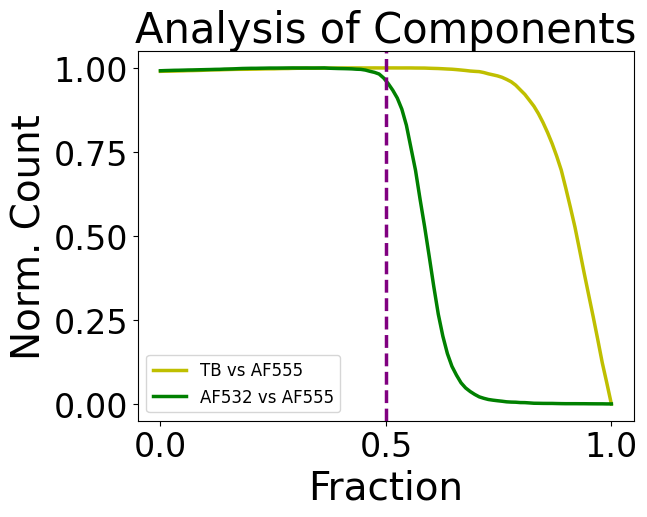

In [157]:
fractions = np.linspace(0.0, 1.0, 100)
counts_mssr = phasor_component_graphical(
    n_real_mssr,
    n_imag_mssr,
    component_real_n,
    component_imag_n,
    fractions=fractions,
    radius=rad,
)

normcountsmssr_0 = (counts_mssr[0] - np.min(counts_mssr[0])) / (np.max(counts_mssr[0]) - np.min(counts_mssr[0]))
normcountsmssr_1 = (counts_mssr[1] - np.min(counts_mssr[1])) / (np.max(counts_mssr[1]) - np.min(counts_mssr[1]))
normcountsmssr_2 = (counts_mssr[2] - np.min(counts_mssr[2])) / (np.max(counts_mssr[2]) - np.min(counts_mssr[2]))

fig, ax = plt.subplots()
#ax.plot(fractions, normcountsmssr_0, '-', label='TB vs AF532', linewidth = lw, color = 'y')
ax.plot(fractions, normcountsmssr_1, '-', label='TB vs AF555', linewidth = lw, color = 'y')
ax.plot(fractions, normcountsmssr_2, '-', label='AF532 vs AF555', linewidth = lw, color = 'g')
ax.set_title('Analysis of Components', fontsize = fontsize)
ax.set_xlabel('Fraction', fontsize = labelsize)
ax.set_ylabel('Norm. Count', fontsize = labelsize)

ax.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0)) # Format y-axis ticks as scientific notation
ax.axvline(0.5, linestyle = '--', linewidth = 2.5, color = 'purple')

ax.legend(fontsize = legend_fontsize)
plt.show()

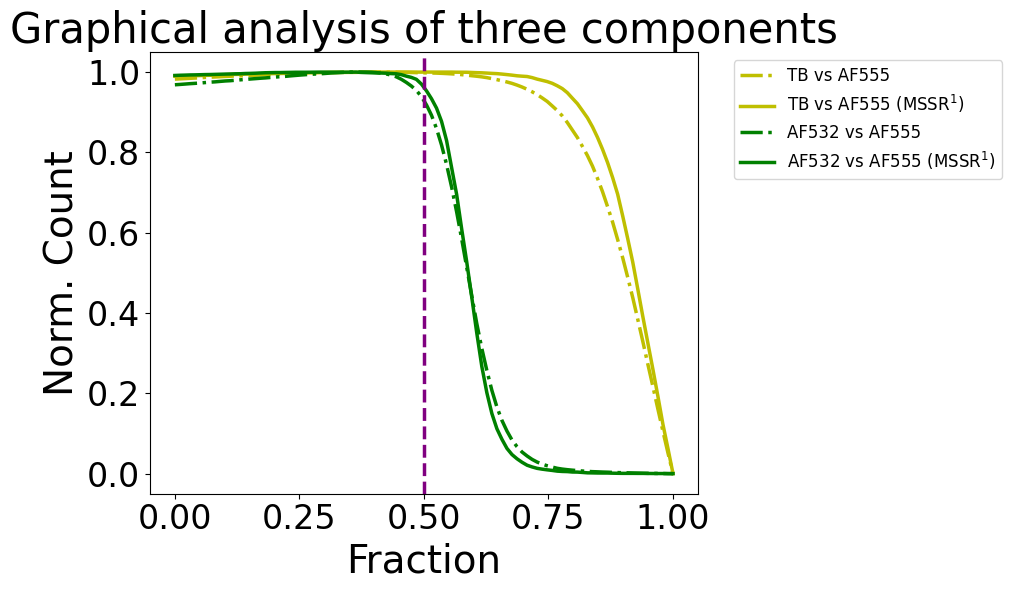

In [158]:
#Figure

legend_fontsize = 12
fig, ax = plt.subplots(figsize=(10, 6)) # Increased figure size

# tau_blur vs AF532
#ax.plot(fractions, normcounts_0, label='TB vs AF532', linewidth = lw, linestyle = 'dashdot', color = 'y')
#ax.plot(fractions, normcountsmssr_0, label='TB vs AF532 (MSSR$^1$)', linewidth = lw, color = 'y')

#tau_blur vs AF555
ax.plot(fractions, normcounts_1, label='TB vs AF555', linewidth = lw, linestyle = 'dashdot', color = 'y')
ax.plot(fractions, normcountsmssr_1, label='TB vs AF555 (MSSR$^1$)', linewidth = lw, color = 'y')

#AF532 vs AF555
ax.plot(fractions, normcounts_2, label='AF532 vs AF555', linewidth = lw, linestyle = 'dashdot', color = 'g')
ax.plot(fractions, normcountsmssr_2, label='AF532 vs AF555 (MSSR$^1$)', linewidth = lw, color = 'g')

#Figure setup
ax.set_title('Graphical analysis of three components', fontsize = fontsize)
ax.set_xlabel('Fraction', fontsize = labelsize)
ax.set_ylabel('Norm. Count', fontsize = labelsize)

ax.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0)) # Format y-axis ticks as scientific notation
ax.axvline(0.5, linestyle = '--', linewidth = 2.5, color = 'purple')

ax.legend(fontsize = legend_fontsize, bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside
plt.tight_layout() # Adjust layout to prevent legend overlap
plt.show()

## Phasor Metrics

### Phasor Histograms metrics

In [159]:
G_before = n_real
S_before = n_imag
G_after = n_real_mssr
S_after = n_imag_mssr

# --- Run the phasor metrics function ---
results = compute_phasor_metrics(G_before, S_before, G_after, S_after)

# --- Print results ---
#for k, v in results.items():
    #if isinstance(v, (float, np.floating)):   # format floats to 4 decimals
        #print(f"{k:25s}: {v: .4f}")
    #elif isinstance(v, (tuple, list)) and all(isinstance(x, (float, np.floating)) for x in v):
        #formatted = ", ".join([f"{x:.4f}" for x in v])
        #print(f"{k:25s}: ({formatted})")
    #else:  # integers or other types
        #print(f"{k:25s}: {v}")


--- Phasor Metrics ---
n_points_before          : 226814
n_points_after           : 24535
centroid_before          : (0.6826, 0.4032)
centroid_after           : (0.6720, 0.4109)
centroid_displacement    :  0.0131
ellipse_area_before      :  0.0318
ellipse_area_after       :  0.0278
area_ratio               :  0.8721
anisotropy_before        :  2.0032
anisotropy_after         :  3.0176
anisotropy_ratio         :  1.5064
covariance_before        : [[ 0.00302614 -0.00088722]
 [-0.00088722  0.00120475]]
covariance_after         : [[ 0.00398845 -0.00127003]
 [-0.00127003  0.00094949]]
sigma_GS_before          : -0.0009
sigma_GS_after           : -0.0013
orientation_before_deg   : -22.1259
orientation_after_deg    : -19.9450
orientation_change_deg   :  2.1809


### Fraction Histograms metrics

In [160]:
#Real Data

before = normcounts_1
after = normcountsmssr_1

# Compute metrics
results = compute_fraction_metrics(fractions, before, after)


--- Fraction Metrics ---
variance_before     :  7.198491e-06
variance_after      :  6.009060e-06
overlap_coefficient :  9.830472e-01
JSD                 :  inf
f_star_before       :  9.595960e-01
f_star_after        :  9.595960e-01
delta_f_star        :  0.000000e+00
slope_before        : -6.321147e-02
slope_after         : -7.405218e-02
FWHM_before         :  9.000000e-01
FWHM_after          :  9.200000e-01
KS_statistic        :  6.700000e-01
KS_p_value          :  1.334180e-21
permutation_p_value :  1.000000e+00


## (Change the workflow for the) Multicomponent Analysis on ROIs

### Before $\mathrm{MSSR^1}$

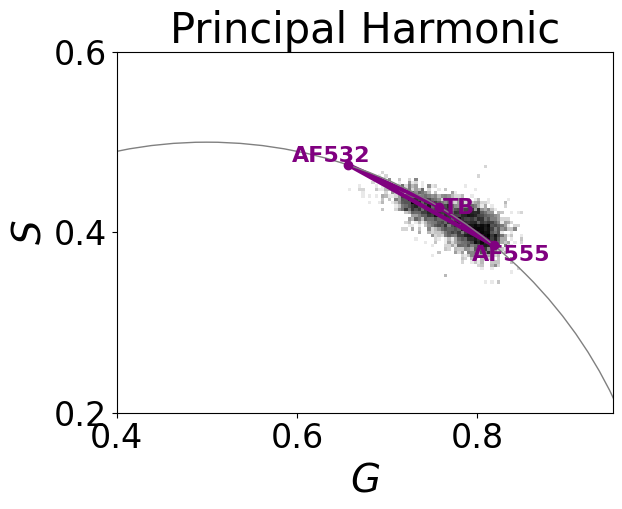

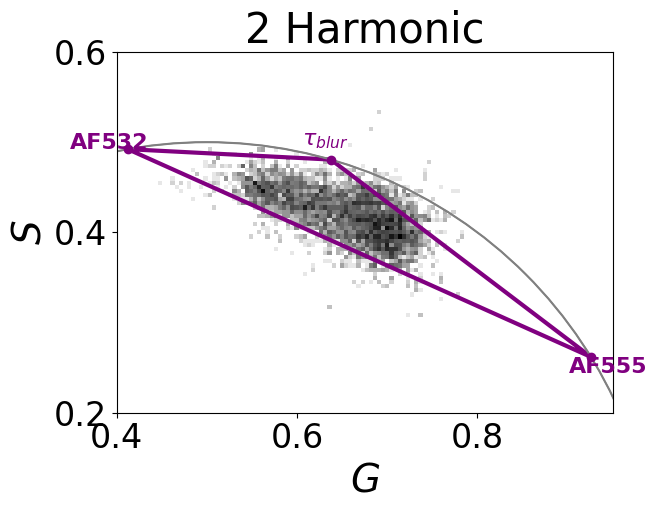

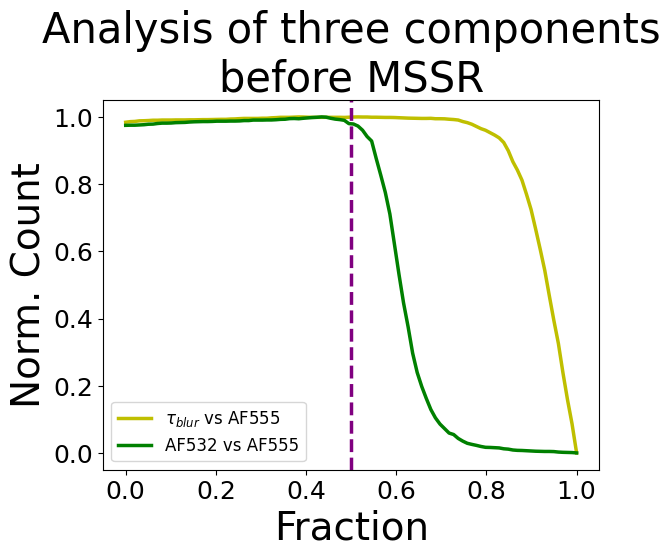

In [161]:
# 2nd harmonic transformation

component_lifetimes_nharm = [1.2, 1.9, 0.45] #In order [tau_blur, AF532, AF555]

rad = 0.09
fractions = np.linspace(0.0, 1.0, 100)

# Calculate the phasor components at the n-th harmonic
n = 2 # number of harmonic
real_th_zoom_2, imag_th_zoom_2 = phasor_harmonic_transform(real_th_zoom, imag_th_zoom, harmonic=n)

# Calibration

n_real_zm, n_imag_zm = phasor_calibrate(
    real_th_zoom_2,
    imag_th_zoom_2,
    reference_mean,
    reference_real,
    reference_imag,
    frequency=n_freq,
    lifetime=reference_lifetime,
)

# Plotting the Principal harmonic phasor

plot = PhasorPlot(xlim=(0.4, 0.95), ylim=(0.2, 0.6), allquadrants=False, title='Principal Harmonic')
plot.hist2d(real_th_zoom, imag_th_zoom, cmap='Greys', bins = 150)
#plot.semicircle(frequency, linewidth= 1.5)
#plot.contour(real_th, imag_th, bins=50, levels=18, cmap='summer_r', norm='log')
plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
plt.title('Principal Harmonic', fontsize = fontsize)


#3 component analysis
plot.components(
    component_real, component_imag, labels=['TB','AF532', 'AF555'], **component_style
)

plt.show()

# Plotting the nth- harmonic phasor

plot = PhasorPlot(xlim=(0.4, 0.95), ylim=(0.2, 0.6), allquadrants=False, title=f'{n} Harmonic')
plot.hist2d(n_real_zm, n_imag_zm, cmap='Greys', bins = 120)
plot.semicircle(linewidth= 1.5)
plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
plt.title(f'{n} Harmonic', fontsize = fontsize)

#3 component analysis

component_real_n, component_imag_n = phasor_from_lifetime(
    n_freq, component_lifetimes_nharm
)
plot.components(
    component_real_n, component_imag_n, labels=['$\u03c4_{blur}$', 'AF532', 'AF555'], **component_style
)

#Fraction Plot

countszm = phasor_component_graphical(
    n_real_zm,
    n_imag_zm,
    component_real_n,
    component_imag_n,
    fractions=fractions,
    radius=rad,
)

normcountszm_0 = (countszm[0] - np.min(countszm[0])) / (np.max(countszm[0]) - np.min(countszm[0]))
normcountszm_1 = (countszm[1] - np.min(countszm[1])) / (np.max(countszm[1]) - np.min(countszm[1]))
normcountszm_2 = (countszm[2] - np.min(countszm[2])) / (np.max(countszm[2]) - np.min(countszm[2]))

fig, ax = plt.subplots()
#ax.plot(fractions, normcountszm_0, '-', label='$\u03c4_{blur}$ vs AF532', linewidth = lw, color = 'y')
ax.plot(fractions, normcountszm_1, '-', label='$\u03c4_{blur}$ vs AF555', linewidth = lw, color = 'y' )
ax.plot(fractions, normcountszm_2, '-', label='AF532 vs AF555', linewidth = lw, color = 'g')
ax.set_title('Analysis of three components\nbefore MSSR', fontsize = fontsize)
ax.set_xlabel('Fraction', fontsize = labelsize)
ax.set_ylabel('Norm. Count', fontsize = labelsize)
ax.tick_params(axis='both', labelsize=18) # Adjust labelsize as needed  which='major'
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0)) # Format y-axis ticks as scientific notation
ax.axvline(0.5, linestyle = '--', linewidth = 2.5, color = 'purple')
ax.legend(fontsize = legend_fontsize)
plt.show()

plt.show()

### After $\mathrm{MSSR^1}$

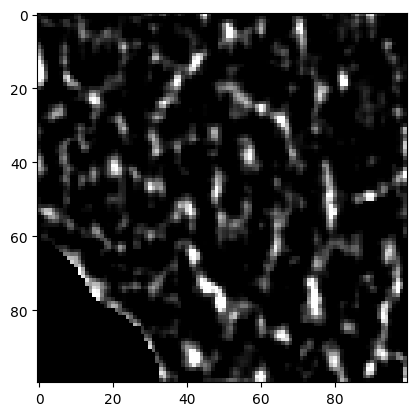

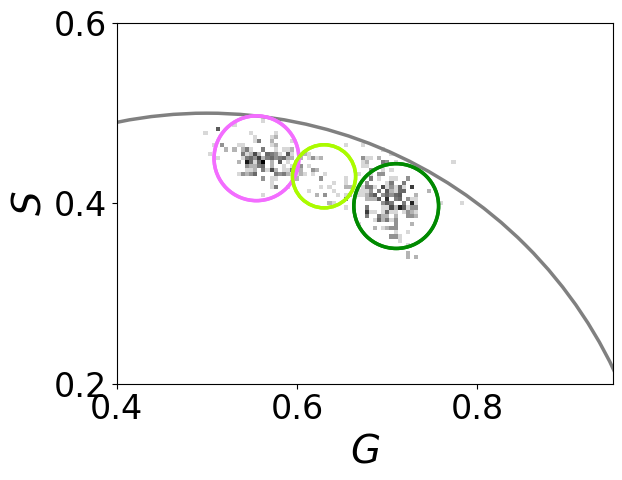

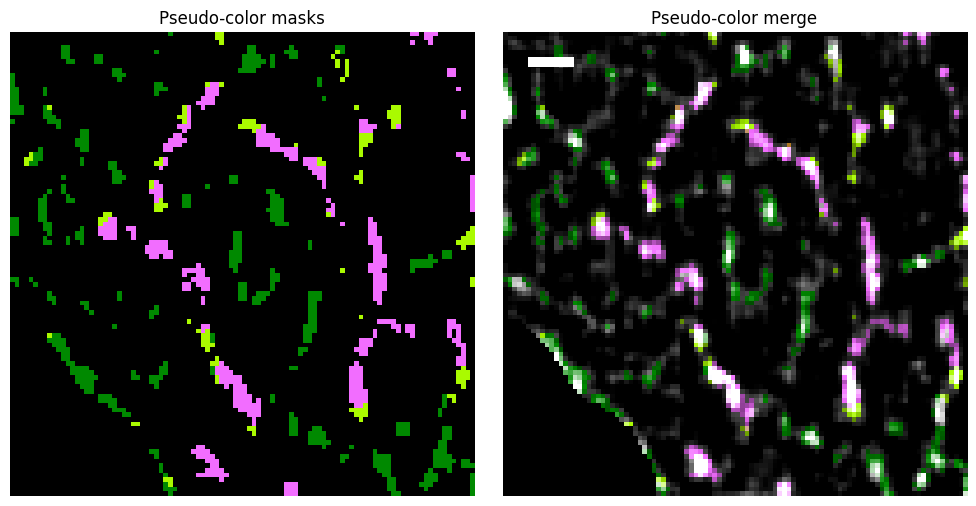

In [162]:
# Apply MSSR mask to the 2nd Harmonic G/S matrices
# At this point MSSR1 was alreadey done to the intensity based image, we are going to called that mask again to mask for the G/S 2nd harmonic matrices
# mean_mssr1

intensity = mean_mssr1_zoom

plt.imshow(intensity, cmap='gray', vmin=0, vmax=0.25)

## Threshold
n_mean_zm_mssr, n_real_zm_mssr, n_imag_zm_mssr = phasor_threshold(intensity, n_real_zm, n_imag_zm, mean_min=0.07)

cursors_real = [0.71, 0.555, 0.01, 0.63]      # cursors_real = [0.82, 0.7, 0.755]
cursors_imag = [0.397, 0.45, 0.01, 0.43]      # cursors_imag = [0.39, 0.445, 0.42]
radius = [0.047, 0.047, 0.01, 0.035]           # radius = [0.04, 0.03, 0.03]

#circular cursor to the MSSR thresholded G/S 2nd harmonic matrices
circular_mask = mask_from_circular_cursor(
    n_real_zm_mssr, n_imag_zm_mssr, cursors_real, cursors_imag, radius=radius
)


plot = PhasorPlot(xlim = (0.4, 0.95), ylim=(0.2, 0.6), allquadrants=False, title='Phasor Plot')
plot.semicircle(linewidth= 2.5)
plot.hist2d(n_real_zm_mssr, n_imag_zm_mssr, cmap='Grays', bins = 120)
for i in range(len(cursors_real)):
    plot.cursor(
        cursors_real[i],
        cursors_imag[i],
        radius=radius[i],
        #crosshair=True,
        polar=True,
        color=CATEGORICAL[i+2],
        linestyle='-', linewidth = lw
    )
for i in range(len(cursors_real)):
    plot.cursor(
        cursors_real[i],
        cursors_imag[i],
        radius=radius[i],
        #crosshair=True,
        color=CATEGORICAL[i+2],
        linestyle='-', linewidth = lw
    )
plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', which='major', labelsize=ticksize) # Adjust labelsize as needed
plt.title('', fontsize = fontsize)
plot.show()


pseudo_color_masks = pseudo_color(*circular_mask, intensity = None, colors=CATEGORICAL[2:])
pseudo_color_merge = pseudo_color(*circular_mask, intensity = intensity, colors=CATEGORICAL[2:], vmin=0, vmax=0.25)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

ax1.set_title('Pseudo-color masks')
ax1.imshow(pseudo_color_masks)
ax1.axis('off')

ax2.set_title('Pseudo-color merge')
ax2.imshow(pseudo_color_merge)
ax2.axis('off')

# Add the scale bar
scalebar = patches.Rectangle((x_pos, y_pos), scalebar_width, scalebar_height,
                             linewidth=0, edgecolor=None, facecolor=bar_color)
ax2.add_patch(scalebar)

plt.tight_layout()
plt.show()

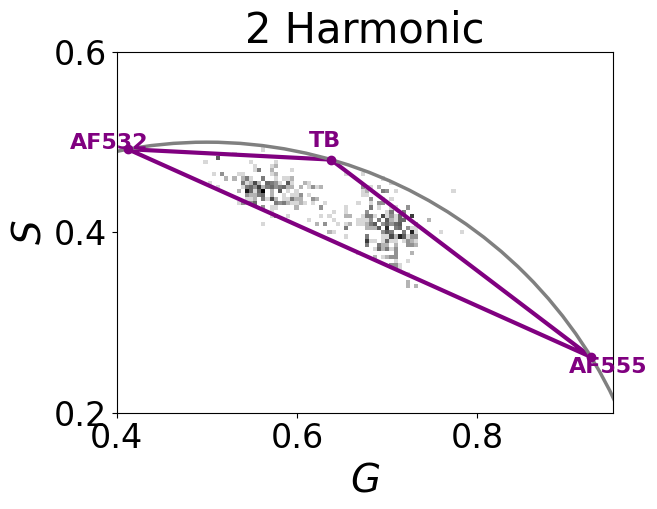

In [163]:
plot = PhasorPlot(xlim=(0.4, 0.95), ylim=(0.2, 0.6), allquadrants=False, title=f'{n} Harmonic')
plot.hist2d(n_real_zm_mssr, n_imag_zm_mssr, cmap='Greys', bins = 120)
plot.semicircle(linewidth= 2.5)
#plot.contour(n_real, n_imag, bins=50, levels=18, cmap='summer_r', norm='log')
plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
plt.title(f'{n} Harmonic', fontsize = fontsize)

#3 component analysis
component_lifetimes_nharm = [1.2, 1.9, 0.45] #In order [tau_blur, AF532, AF555]
component_real_n, component_imag_n = phasor_from_lifetime(
    n_freq, component_lifetimes_nharm
)
plot.components(
    component_real_n, component_imag_n, labels=['TB', 'AF532', 'AF555'], **component_style
)

plot.show()

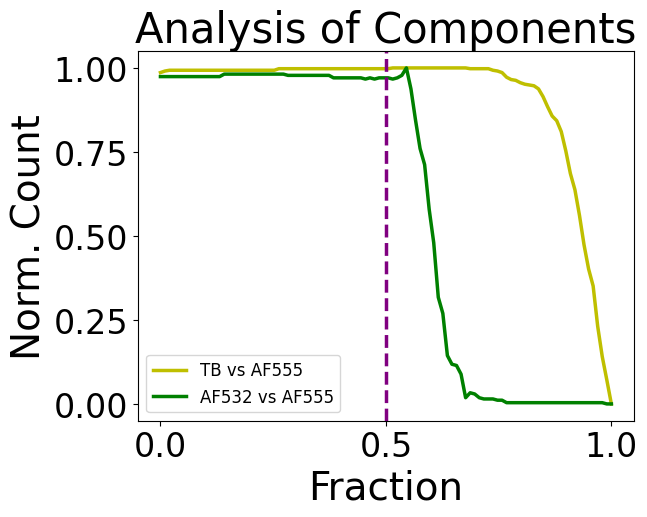

In [164]:
fractions = np.linspace(0.0, 1.0, 100)
counts_mssr = phasor_component_graphical(
    n_real_zm_mssr,
    n_imag_zm_mssr,
    component_real_n,
    component_imag_n,
    fractions=fractions,
    radius=rad,
)

normcountszmmssr_0 = (counts_mssr[0] - np.min(counts_mssr[0])) / (np.max(counts_mssr[0]) - np.min(counts_mssr[0]))
normcountszmmssr_1 = (counts_mssr[1] - np.min(counts_mssr[1])) / (np.max(counts_mssr[1]) - np.min(counts_mssr[1]))
normcountszmmssr_2 = (counts_mssr[2] - np.min(counts_mssr[2])) / (np.max(counts_mssr[2]) - np.min(counts_mssr[2]))

fig, ax = plt.subplots()
#ax.plot(fractions, normcountszmmssr_0, '-', label='TB vs AF532', linewidth = lw, color = 'y')
ax.plot(fractions, normcountszmmssr_1, '-', label='TB vs AF555', linewidth = lw, color = 'y')
ax.plot(fractions, normcountszmmssr_2, '-', label='AF532 vs AF555', linewidth = lw, color = 'g')
ax.set_title('Analysis of Components', fontsize = fontsize)
ax.set_xlabel('Fraction', fontsize = labelsize)
ax.set_ylabel('Norm. Count', fontsize = labelsize)

ax.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0)) # Format y-axis ticks as scientific notation
ax.axvline(0.5, linestyle = '--', linewidth = 2.5, color = 'purple')

ax.legend(fontsize = legend_fontsize)
plt.show()

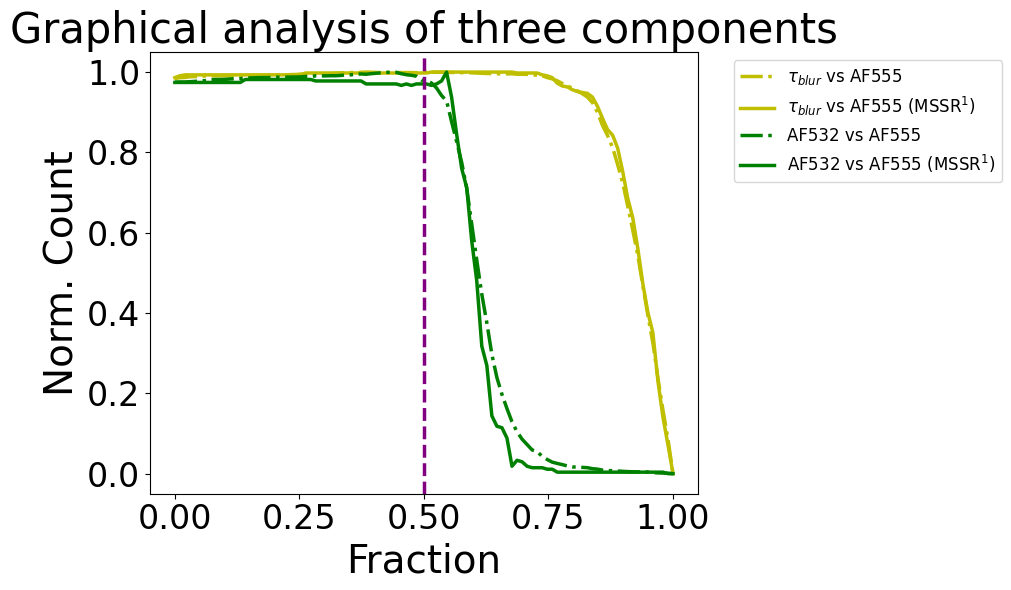

In [165]:
#Figure

legend_fontsize = 12
fig, ax = plt.subplots(figsize=(10, 6)) # Increased figure size

# tau_blur vs AF532
#ax.plot(fractions, normcountszm_0, label='$\u03c4_{blur}$ vs AF532', linewidth = lw, linestyle = 'dashdot', color = 'b')
#ax.plot(fractions, normcountszmmssr_0, label='$\u03c4_{blur}$ vs AF532 (MSSR$^1$)', linewidth = lw, color = 'b')

#tau_blur vs AF555
ax.plot(fractions, normcountszm_1, label='$\u03c4_{blur}$ vs AF555', linewidth = lw, linestyle = 'dashdot', color = 'y')
ax.plot(fractions, normcountszmmssr_1, label='$\u03c4_{blur}$ vs AF555 (MSSR$^1$)', linewidth = lw, color = 'y')

#AF532 vs AF555
ax.plot(fractions, normcountszm_2, label='AF532 vs AF555', linewidth = lw, linestyle = 'dashdot', color = 'g')
ax.plot(fractions, normcountszmmssr_2, label='AF532 vs AF555 (MSSR$^1$)', linewidth = lw, color = 'g')

#Figure setup
ax.set_title('Graphical analysis of three components', fontsize = fontsize)
ax.set_xlabel('Fraction', fontsize = labelsize)
ax.set_ylabel('Norm. Count', fontsize = labelsize)

ax.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0)) # Format y-axis ticks as scientific notation
ax.axvline(0.5, linestyle = '--', linewidth = 2.5, color = 'purple')

ax.legend(fontsize = legend_fontsize, bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside
plt.tight_layout() # Adjust layout to prevent legend overlap
plt.show()

### Phasor Metrics

In [166]:
G_before = n_real_zm
S_before = n_imag_zm
G_after = n_real_zm_mssr
S_after = n_imag_zm_mssr

# --- Run the phasor metrics function ---
results = compute_phasor_metrics(G_before, S_before, G_after, S_after)

#Real Data

before = normcountszm_1
after = normcountszmmssr_1

# Compute metrics
results = compute_fraction_metrics(fractions, before, after)


--- Phasor Metrics ---
n_points_before          : 9417
n_points_after           : 1203
centroid_before          : (0.6529, 0.4197)
centroid_after           : (0.6411, 0.4236)
centroid_displacement    :  0.0125
ellipse_area_before      :  0.0263
ellipse_area_after       :  0.0265
area_ratio               :  1.0048
anisotropy_before        :  2.6803
anisotropy_after         :  3.8236
anisotropy_ratio         :  1.4265
covariance_before        : [[ 0.0033957  -0.00100706]
 [-0.00100706  0.00087469]]
covariance_after         : [[ 0.00488348 -0.00148736]
 [-0.00148736  0.00085742]]
sigma_GS_before          : -0.0010
sigma_GS_after           : -0.0015
orientation_before_deg   : -19.3113
orientation_after_deg    : -18.2297
orientation_change_deg   :  1.0816

--- Fraction Metrics ---
variance_before     :  5.052148e-06
variance_after      :  4.974792e-06
overlap_coefficient :  9.973997e-01
JSD                 :  inf
f_star_before       :  9.898990e-01
f_star_after        :  9.696970e-01
delta